In [1]:
import glob

In [2]:
from astroquery.svo_fps import SvoFps

In [3]:
jfilts = SvoFps.get_filter_list('JWST')
jfilts.add_index('filterID')

In [4]:
import numpy as np

In [5]:
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC
from astropy import units as u

In [6]:
ext = CT06_MWGC()
ext(2.12*u.um) * 30, ext(4.8*u.um) * 30

(3.4232313962264147, 1.454796)

In [7]:
geoms = [x.split("/")[-2] for x in glob.glob('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/*/')
         if x.split("/")[-2].startswith('s')]
geoms

['s---s-i',
 's-pbsmi',
 's-p-hmi',
 'spu-hmi',
 'spubsmi',
 's-pbhmi',
 's-u-smi',
 's-ubhmi',
 'spu-smi',
 's-u-hmi',
 's-ubsmi',
 'sp--hmi',
 'sp--s-i',
 'spubhmi',
 's---smi',
 'sp--smi',
 's-p-smi',
 'sp--h-i']

In [8]:
from astropy.table import Table
f480s = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/NIRCam.F480M.fits')
         for geom in geoms}

In [9]:
f212s = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/NIRCam.F212N.fits')
         for geom in geoms}

In [10]:
v1 = Table.read('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.1/s---s-i/convolved/I1.fits')
v2 = Table.read('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/s---s-i/convolved/Spitzer/IRAC.I1.fits')

In [11]:
path='/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/spubsmi/convolved/JWST/'
f770 = Table.read(f'{path}/MIRI.F770W.fits')
f470 =  Table.read(f'{path}/NIRCam.F470N.fits')

In [12]:
augpars_dict = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/pars/{geom}_augmented.fits')
                for geom in geoms}
for key in augpars_dict:
    augpars_dict[key].add_index("MODEL_NAME")

In [13]:
augpars_dict['s---s-i'][:5]

<Table length=5>
 MODEL_NAME star.radius star.temperature scattering inclination   Model Luminosity 
                                                                       solLum      
  bytes20     float64       float64        int64      float64         float64      
----------- ----------- ---------------- ---------- ----------- -------------------
01QyhoBc_01      0.2728           4888.0          1        45.0 0.03827429493798022
01Xx6elC_01       0.383          12050.0          1        45.0  2.7863740310410456
03ZZRVTe_01       31.22           4967.0          1        45.0   534.4857312835463
03amqKIp_01       13.81           7891.0          1        45.0   666.2070265981496
03dloFhH_01       44.63           6450.0          1        45.0  3105.8917167595805

# Theo's classification downselection

 * MS: 0 (below) / 1 (on/above) / -1 (too cold)
 * Stage: 0 (0) / 1 (I) / 2 (II) / 3 (III) / -1 (none)
 * Class: 0 (0) / 1 (I) / 2 (Flat) / 3 (II) / 4 (III) / -1 (none)

In [14]:
classification_dict = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/real_models/{geom}.fits')
                       for geom in geoms}
for key in classification_dict:
    classification_dict[key].add_index("Model Name")

In [15]:
f470s = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/NIRCam.F470N.fits')
         for geom in geoms}

In [16]:
f470s['sp--h-i'][:5]

<Table length=5>
 MODEL_NAME                TOTAL_FLUX                             TOTAL_FLUX_ERR             
                              mJy                                      mJy                   
  bytes30                 float64[20]                              float64[20]               
----------- ---------------------------------------- ----------------------------------------
016nTMSL_01 10.932071685791016 .. 10.932223320007324  10.926067352294922 .. 10.92621898651123
016nTMSL_02  10.94102954864502 .. 10.941184997558594 10.935020446777344 .. 10.935175895690918
016nTMSL_03 10.976465225219727 .. 10.976628303527832 10.970436096191406 .. 10.970599174499512
016nTMSL_04 11.043643951416016 .. 11.043824195861816 11.037578582763672 .. 11.037758827209473
016nTMSL_05 11.080031394958496 .. 11.080085754394531 11.073945999145508 .. 11.074000358581543

In [17]:
import pylab as pl
import numpy as np
from astropy import units as u

/home/t.yoo/anaconda3/envs/adam_env/lib/python3.11/site-packages/astropy/units/function/logarithmic.py:66: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))


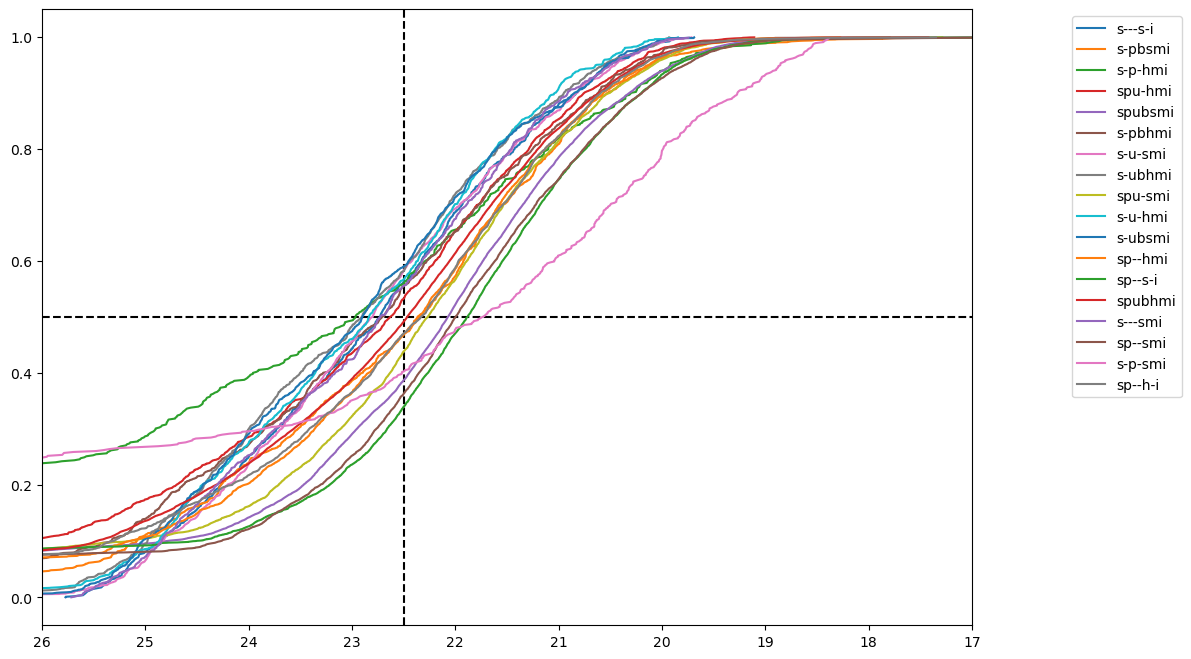

In [18]:
pl.figure(figsize=(12,8))
for geom in geoms:
    pars = augpars_dict[geom]
    f470 = f470s[geom]
    lum = pars['Model Luminosity']
    lumsel = (lum > 0.05) & (lum < 0.5)
    if any(lumsel):
        #pl.hist(f470['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
        rslt = f470['TOTAL_FLUX'][lumsel, 5]
        rslt = rslt[np.isfinite(rslt)]
        rslt = np.sort(rslt)
        pl.plot((rslt / (8.5**2)).to(u.ABmag), np.arange(len(rslt)) / len(rslt), label=geom)
pl.legend(loc='upper left', bbox_to_anchor=(1.1,1))
pl.xlim(1e-5,5)
pl.axvline(22.5, linestyle='--', color='k', zorder=-50)
pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
pl.xlim(26, 17);
#pl.semilogx();

18.739813532572736 20.14778607034496 26.264743371696156


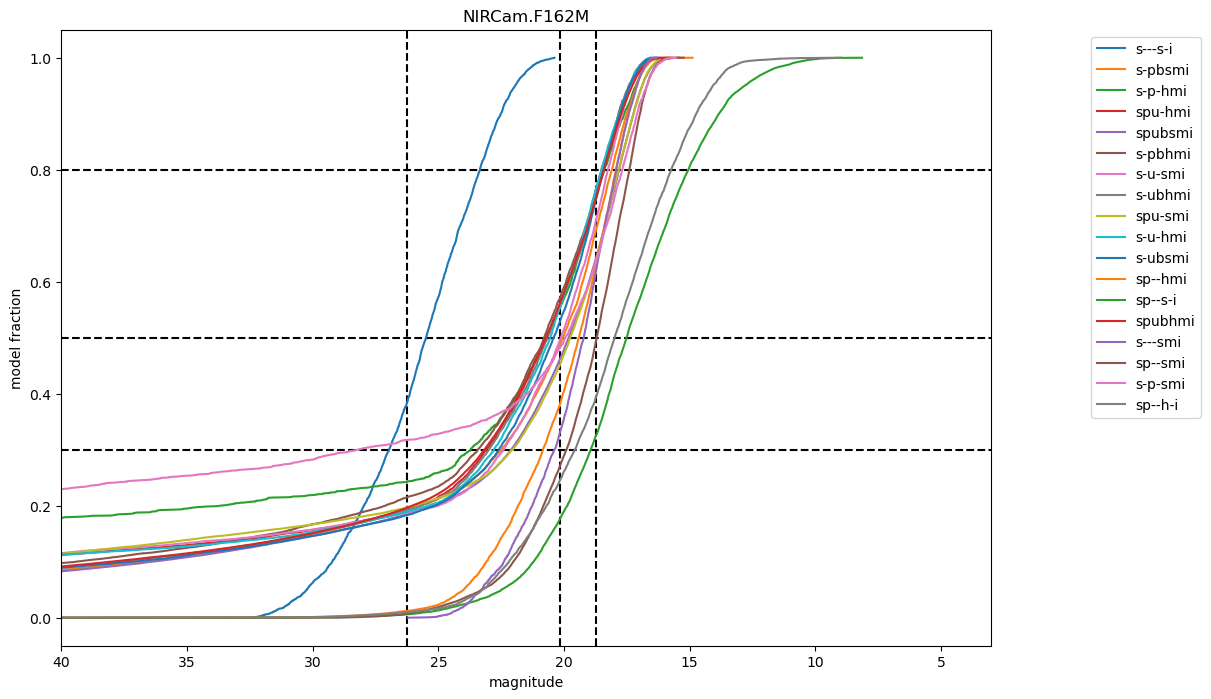

17.376526421812038 18.81107990921727 25.104701342216536


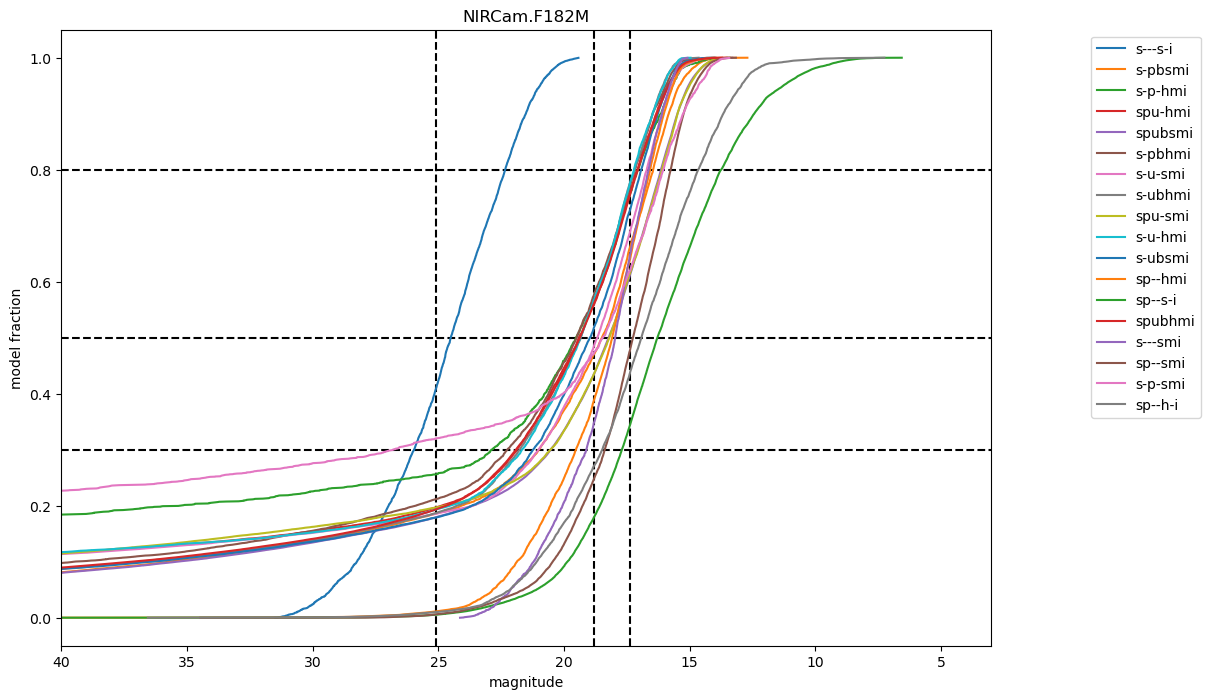

17.124161412316052 18.54983983335494 24.727592635356654


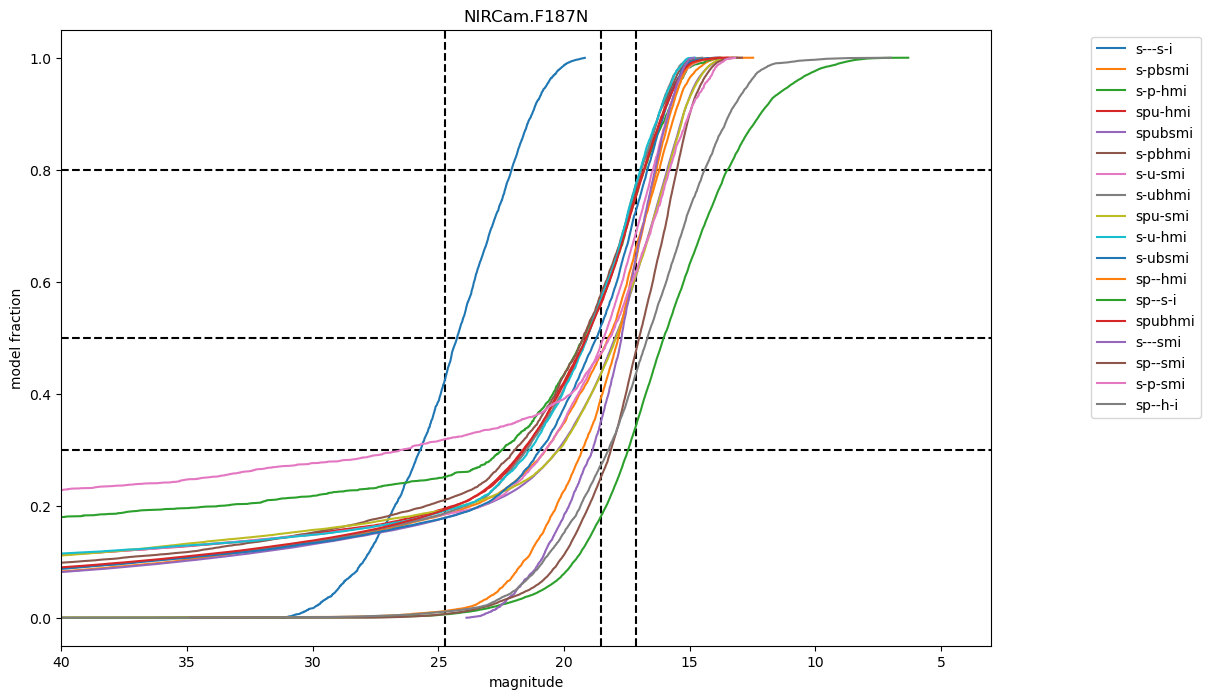

16.108318074558785 17.59139558096365 23.82454310166898


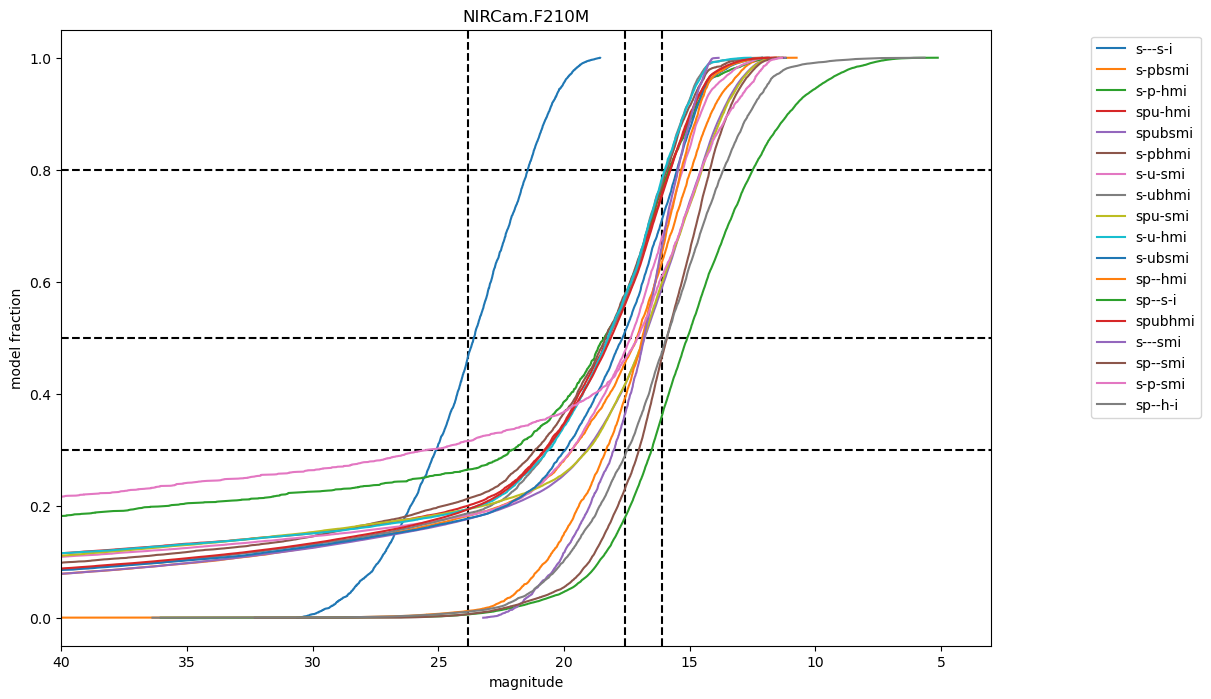

13.259094508192339 14.927834685814279 20.67292500155741


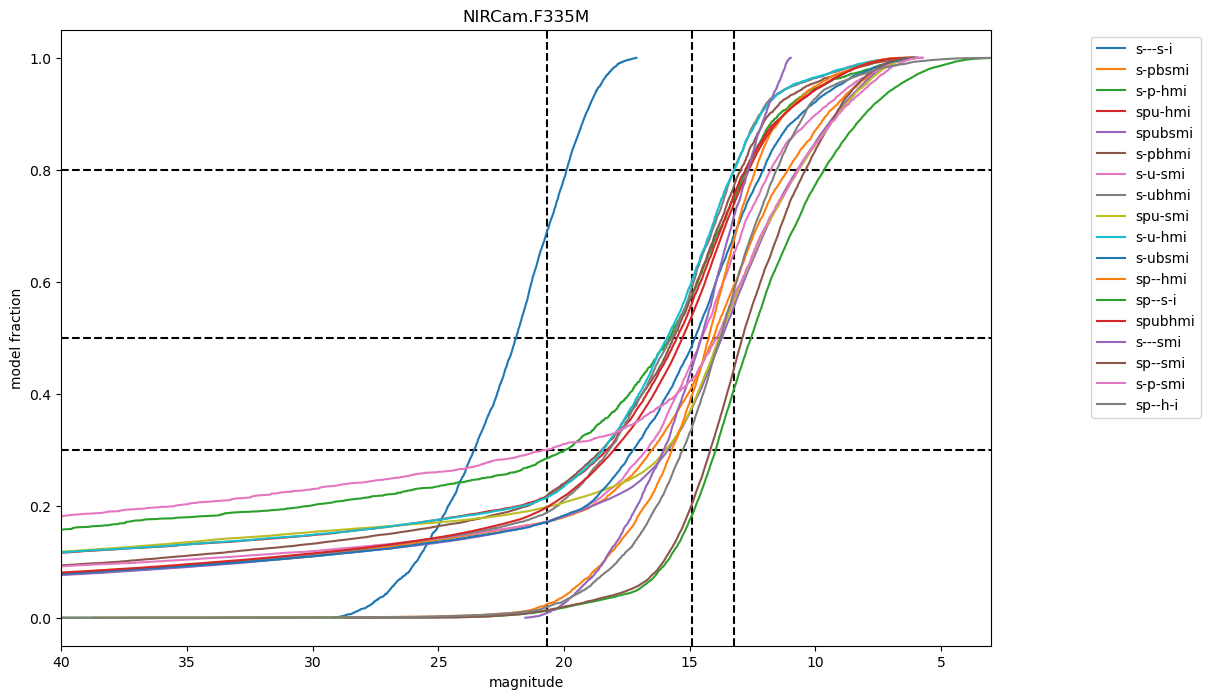

12.925672487044988 14.61299079816217 20.29756913308389


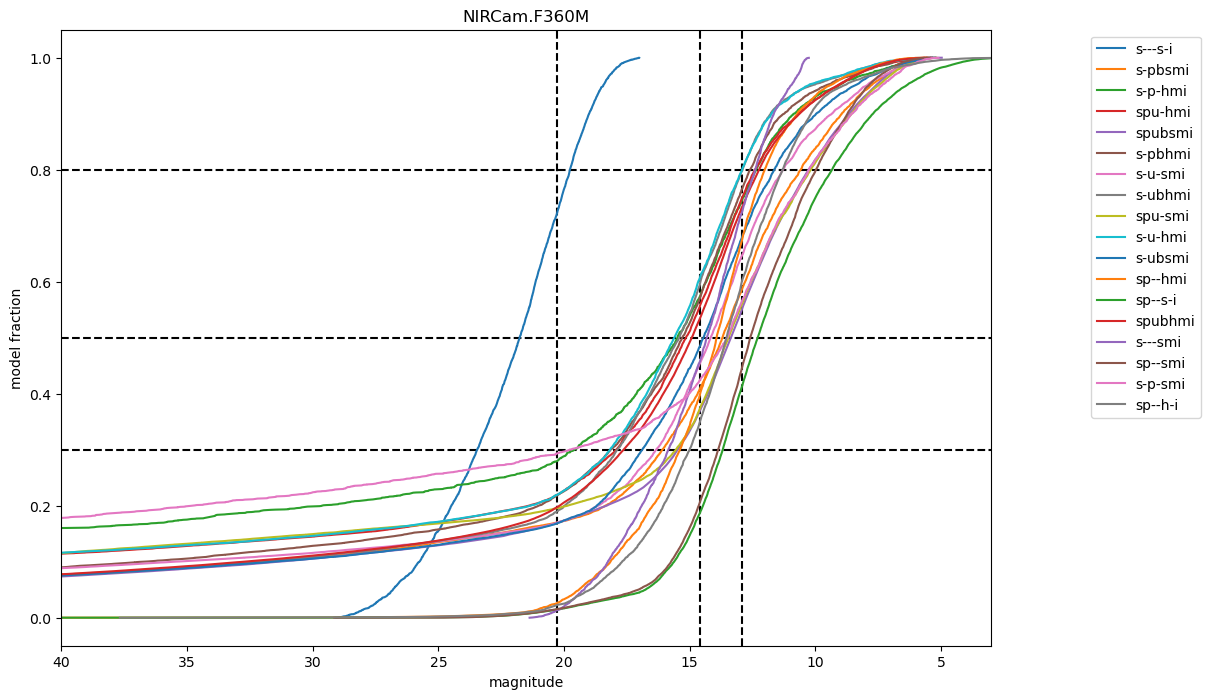

12.423419108839596 14.138580484134998 19.475833518998357


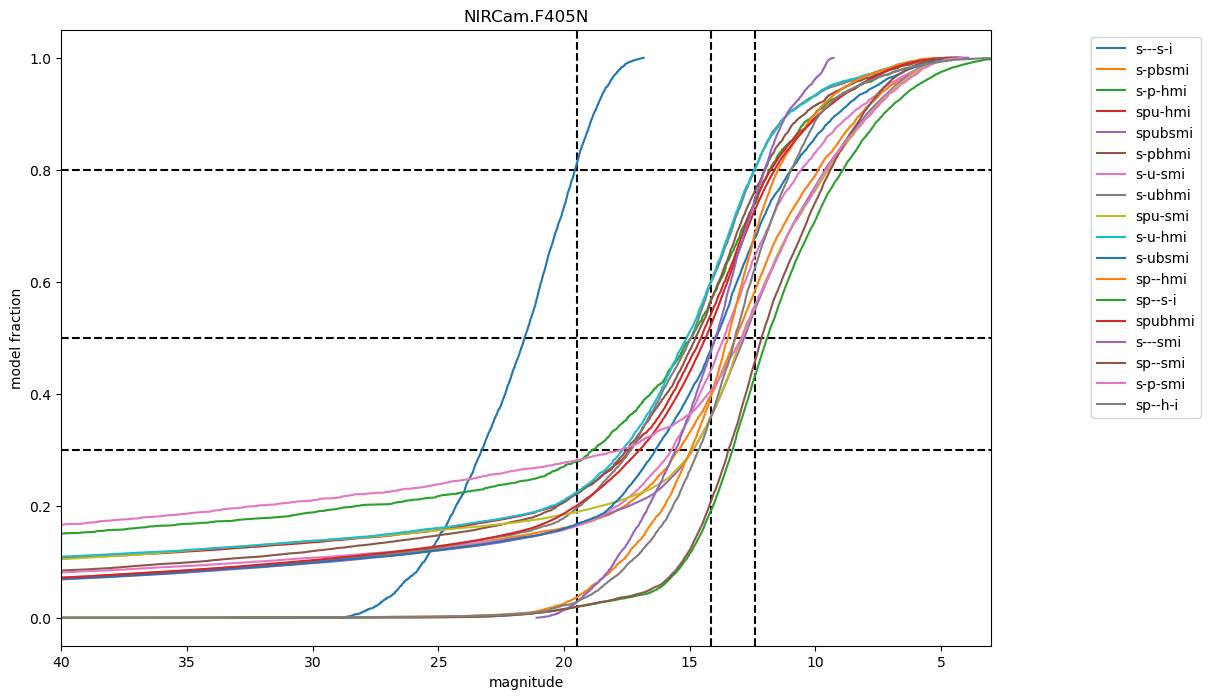

12.424599962221196 14.152753362737165 19.60691875459456


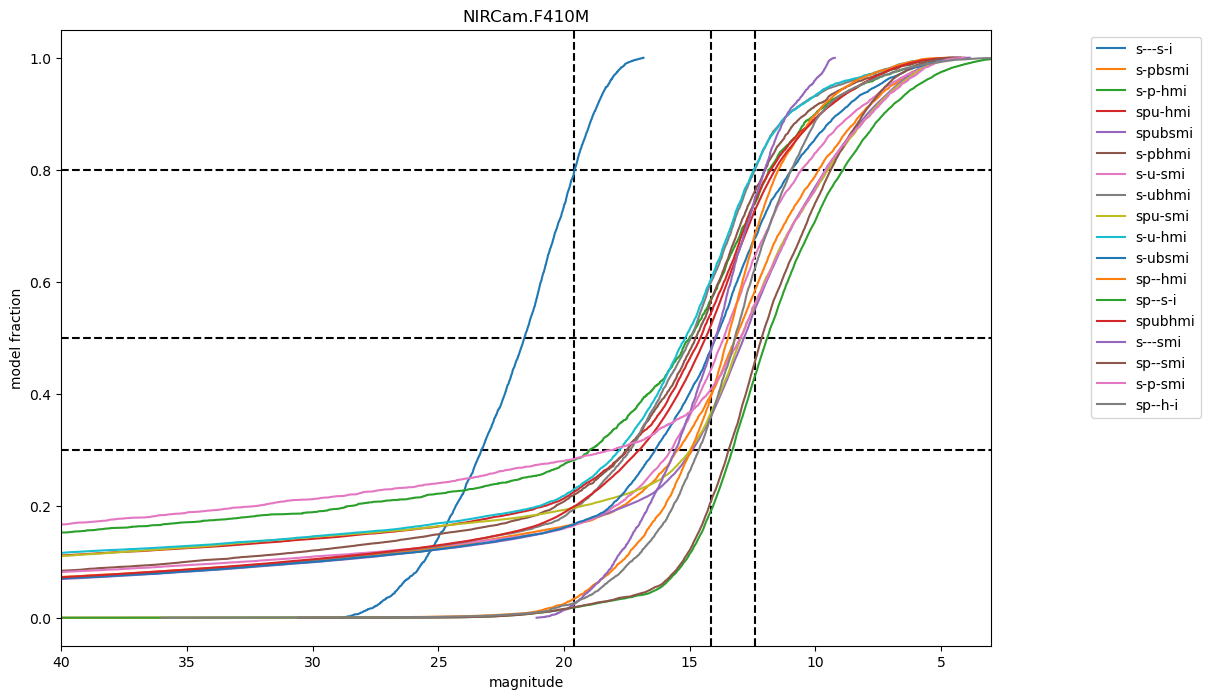

11.835151572271005 13.61884427106782 18.652571564823095


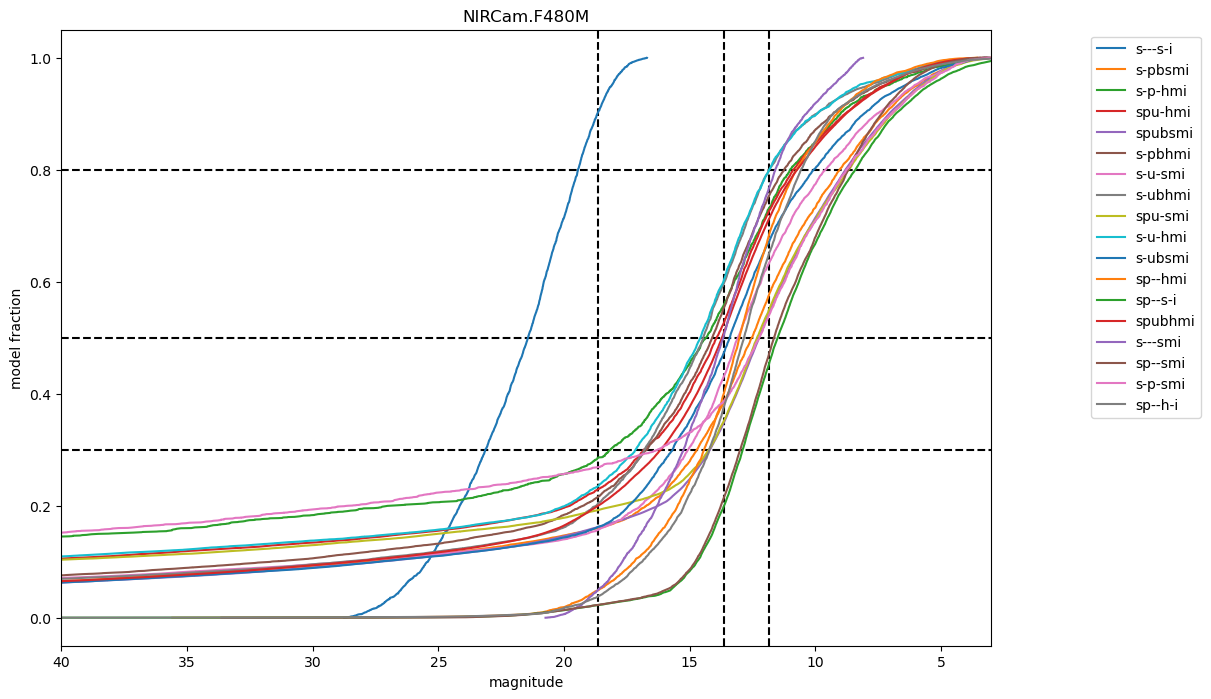

11.29233555688349 13.15232291480132 17.834325474066507


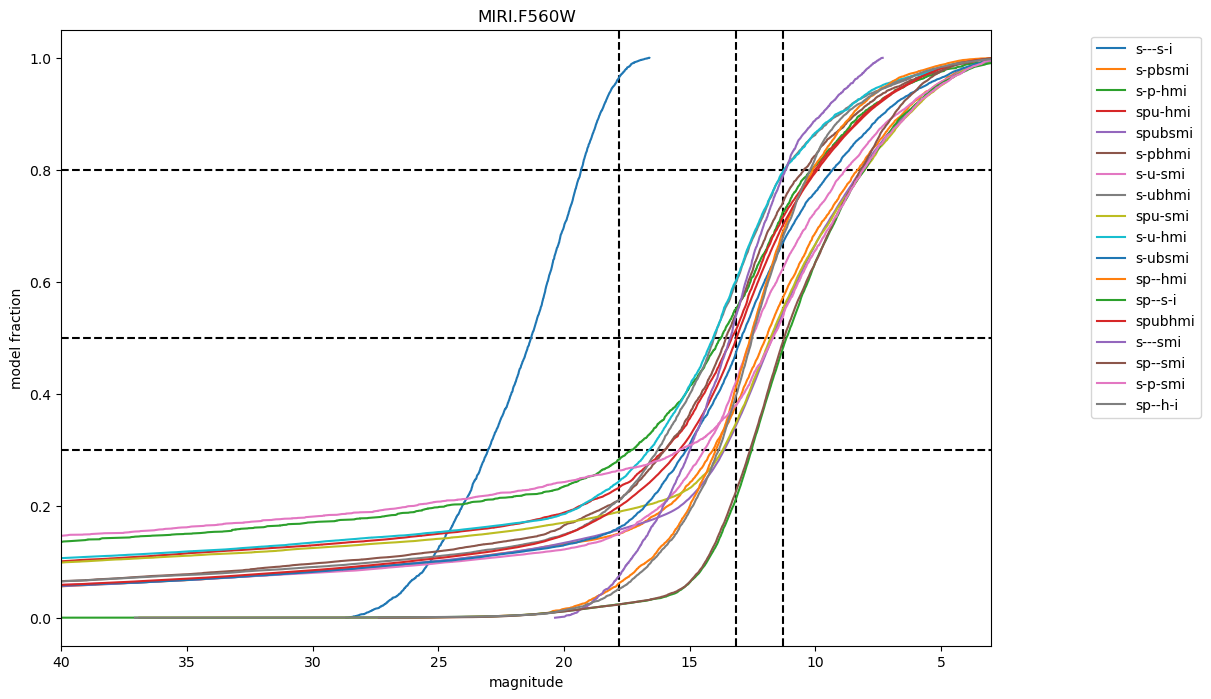

10.194932780320103 12.202608912693673 16.217077443318626


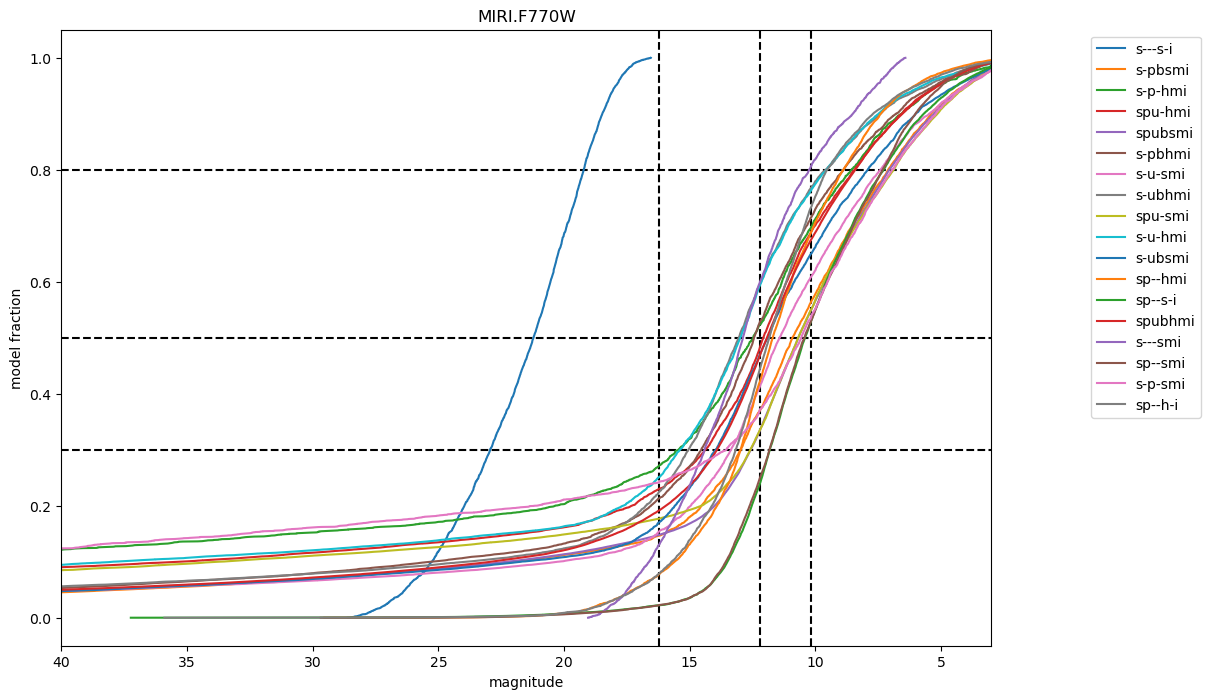

11.090460323271468 13.26681426301998 18.242674313838677


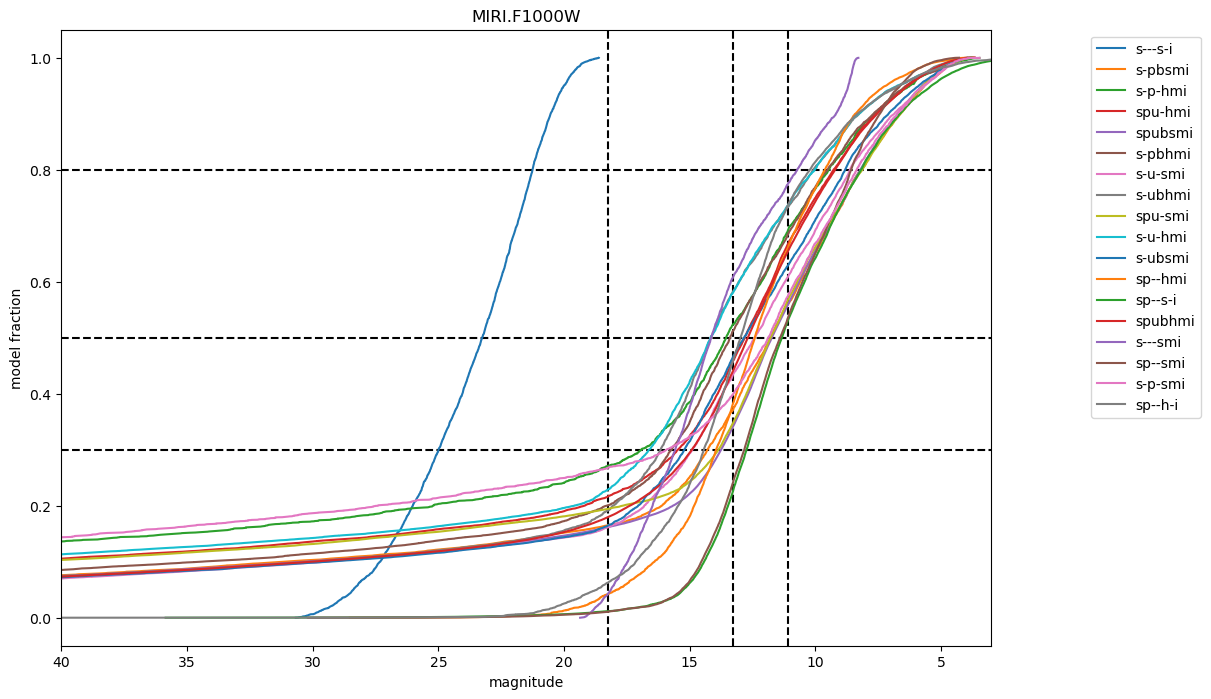

8.657125449693472 10.66037109716283 13.725366753002454


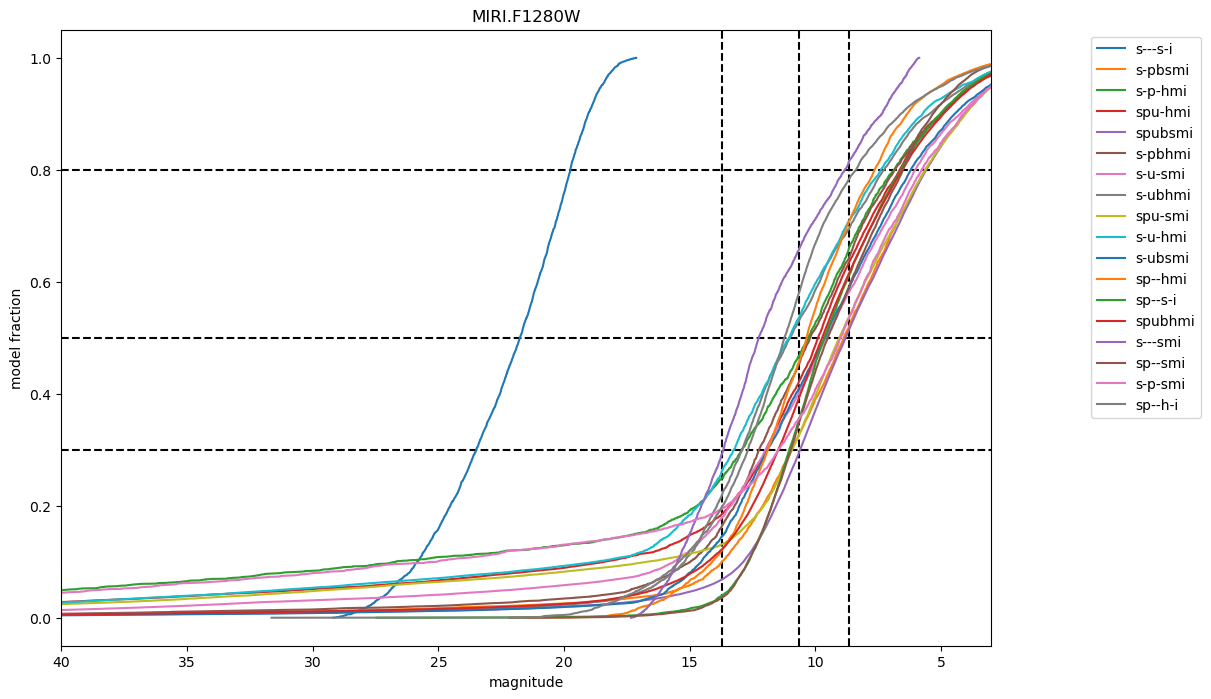

7.480213706008025 9.2522786325973 12.319194871781589


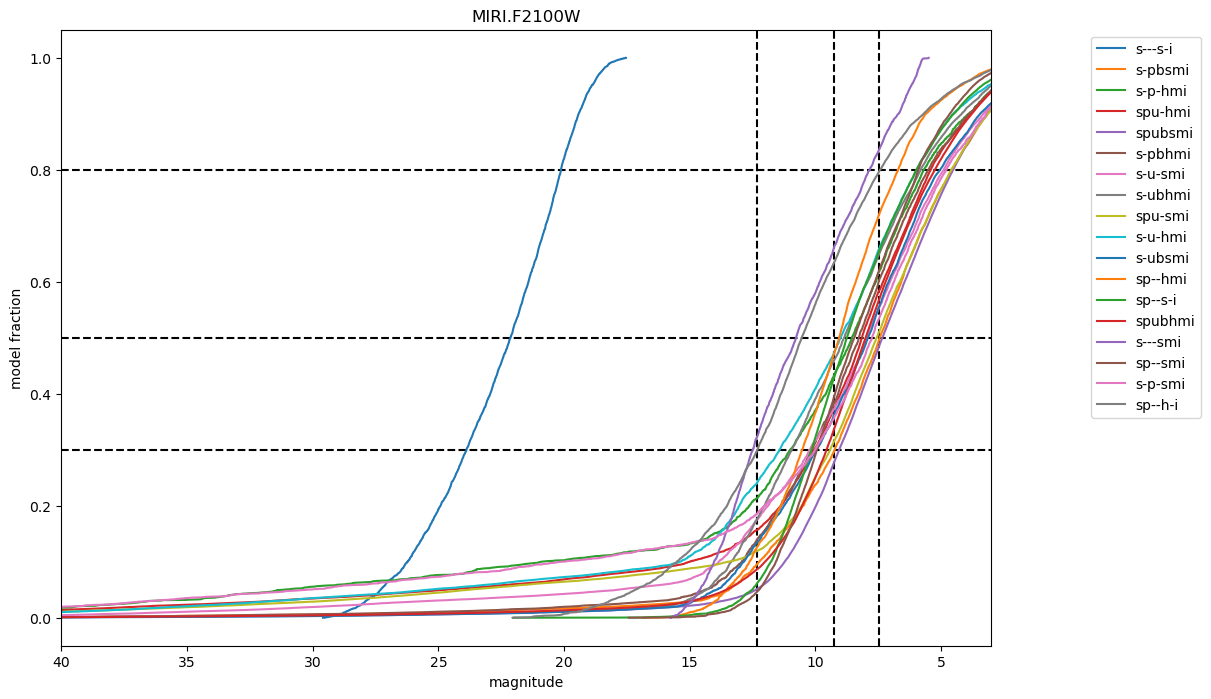

[18.739813532572736, 17.376526421812038, 17.124161412316052, 16.108318074558785, 13.259094508192339, 12.925672487044988, 12.423419108839596, 12.424599962221196, 11.835151572271005, 11.29233555688349, 10.194932780320103, 11.090460323271468, 8.657125449693472, 7.480213706008025] [20.14778607034496, 18.81107990921727, 18.54983983335494, 17.59139558096365, 14.927834685814279, 14.61299079816217, 14.138580484134998, 14.152753362737165, 13.61884427106782, 13.15232291480132, 12.202608912693673, 13.26681426301998, 10.66037109716283, 9.2522786325973] [26.264743371696156, 25.104701342216536, 24.727592635356654, 23.82454310166898, 20.67292500155741, 20.29756913308389, 19.475833518998357, 19.60691875459456, 18.652571564823095, 17.834325474066507, 16.217077443318626, 18.242674313838677, 13.725366753002454, 12.319194871781589] [1.62, 1.82, 1.87, 2.1, 3.35, 3.6, 4.05, 4.1, 4.8, 5.6, 7.7, 10.0, 12.8, 21.0]


In [23]:
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC, G21_MWAvg, D22_MWAvg,CT06_MWLoc
from dust_extinction.parameter_averages import CCM89
ext = CT06_MWLoc()

bandlist = ['NIRCam.F162M', 'NIRCam.F182M', 'NIRCam.F187N', 'NIRCam.F210M', 'NIRCam.F335M', 'NIRCam.F360M', 'NIRCam.F405N',
            'NIRCam.F410M', 'NIRCam.F480M', 'MIRI.F560W', 'MIRI.F770W', 'MIRI.F1000W', 'MIRI.F1280W', 'MIRI.F2100W']
av=30
distance_modulus = 5 * np.log10(540)
mags_30 = [] ; mags_50 = [] ; mags_80 = []
wls = []
geoms = [x.split("/")[-2] for x in glob.glob('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/*/')
         if x.split("/")[-2].startswith('s')]
for band in bandlist:            
    
        
        
    fig = pl.figure(figsize=(12,8))
    
    wl_um = int(band[-4:-1])*u.um/100
    if band == 'MIRI.F1000W' or band== 'MIRI.F1280W' or band=='MIRI.F2100W':
        wl_um = int(band[-5:-1])*u.um/100
    mag_30 = [] ; mag_50 = [] ; mag_80 = [] 
    for geom in geoms:

        geomtab = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/r+23_models-1.1/{geom}/convolved/JWST/{band}.fits')
         for geom in geoms}
        geomtab1 = geomtab[geom]
        
        pars = augpars_dict[geom]
        lum = pars['Model Luminosity']
        lumsel = lum>100

    
        pars = augpars_dict[geom]
        lum = pars['Model Luminosity']
        #lumsel = (lum > 0.05) & (lum < 0.5)
        lumsel = lum>100
        if any(lumsel):
        #pl.hist(f470['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
            rslt = geomtab1['TOTAL_FLUX'][lumsel, 5]
            rslt = rslt[np.isfinite(rslt)]
            rslt = np.sort(rslt)
            mag = -2.5*np.log10(rslt / u.Quantity(jfilts.loc['JWST/'+band]['ZeroPoint'], u.Jy)) +  av * ext(wl_um) + distance_modulus
            pl.plot(mag, np.arange(len(rslt)) / len(rslt), label=geom)
            mag_30.append(np.percentile(mag,30))
            mag_50.append(np.percentile(mag,50))
            mag_80.append(np.percentile(mag,80))
    mags_30.append(np.mean(mag_30))
    mags_50.append(np.mean(mag_50))
    mags_80.append(np.mean(mag_80))
    print(np.mean(mag_30), np.mean(mag_50), np.mean(mag_80))
    wls.append(wl_um.value)
    pl.legend(loc='upper left', bbox_to_anchor=(1.1,1))
    pl.axvline(np.mean(mag_30), linestyle='--', color='k', zorder=-50)
    pl.axhline(0.3, linestyle='--', color='k', zorder=-50)
    pl.axvline(np.mean(mag_50), linestyle='--', color='k', zorder=-50)
    pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
    pl.axvline(np.mean(mag_80), linestyle='--', color='k', zorder=-50)
    pl.axhline(0.8, linestyle='--', color='k', zorder=-50)
    pl.xlim(40, 3)
    pl.ylabel('model fraction')
    pl.xlabel('magnitude')
    pl.title(f'{band}')
    pl.show()
    pl.close()
print(mags_30,mags_50,mags_80,wls)

In [ ]:
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC, G21_MWAvg, D22_MWAvg,CT06_MWLoc
from dust_extinction.parameter_averages import CCM89
ext = CT06_MWLoc()

bandlist = ['NIRCam.F162M', 'NIRCam.F182M', 'NIRCam.F187N', 'NIRCam.F210M', 'NIRCam.F335M', 'NIRCam.F360M', 'NIRCam.F405N',
            'NIRCam.F410M', 'NIRCam.F480M', 'MIRI.F560W', 'MIRI.F770W', 'MIRI.F1000W', 'MIRI.F1280W', 'MIRI.F2100W']
av=30
distance_modulus = 5 * np.log10(540)
mags_30 = [] ; mags_50 = [] ; mags_80 = []
wls = []
geoms = [x.split("/")[-2] for x in glob.glob('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/*/')
         if x.split("/")[-2].startswith('s')]
for band in bandlist:            
    
        
        
    fig = pl.figure(figsize=(12,8))
    
    wl_um = int(band[-4:-1])*u.um/100
    if band == 'MIRI.F1000W' or band== 'MIRI.F1280W' or band=='MIRI.F2100W':
        wl_um = int(band[-5:-1])*u.um/100
    mag_30 = [] ; mag_50 = [] ; mag_80 = [] 
    for geom in geoms:

        geomtab = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/r+23_models-1.1/{geom}/convolved/JWST/{band}.fits')
         for geom in geoms}
        geomtab1 = geomtab[geom]
        
        pars = augpars_dict[geom]
        lum = pars['Model Luminosity']
        lumsel = lum>100

    
        pars = augpars_dict[geom]
        lum = pars['Model Luminosity']
        #lumsel = (lum > 0.05) & (lum < 0.5)
        lumsel = lum>100
        if any(lumsel):
        #pl.hist(f470['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
            rslt = geomtab1['TOTAL_FLUX'][lumsel, 5]
            rslt = rslt[np.isfinite(rslt)]
            rslt = np.sort(rslt)
            mag = -2.5*np.log10(rslt / u.Quantity(jfilts.loc['JWST/'+band]['ZeroPoint'], u.Jy)) +  av * ext(wl_um) + distance_modulus
            mag = 
            pl.plot(mag, np.arange(len(rslt)) / len(rslt), label=geom)
            mag_30.append(np.percentile(mag,30))
            mag_50.append(np.percentile(mag,50))
            mag_80.append(np.percentile(mag,80))
    mags_30.append(np.mean(mag_30))
    mags_50.append(np.mean(mag_50))
    mags_80.append(np.mean(mag_80))
    print(np.mean(mag_30), np.mean(mag_50), np.mean(mag_80))
    wls.append(wl_um.value)
    pl.legend(loc='upper left', bbox_to_anchor=(1.1,1))
    pl.axvline(np.mean(mag_30), linestyle='--', color='k', zorder=-50)
    pl.axhline(0.3, linestyle='--', color='k', zorder=-50)
    pl.axvline(np.mean(mag_50), linestyle='--', color='k', zorder=-50)
    pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
    pl.axvline(np.mean(mag_80), linestyle='--', color='k', zorder=-50)
    pl.axhline(0.8, linestyle='--', color='k', zorder=-50)
    pl.xlim(40, 3)
    pl.ylabel('model fraction')
    pl.xlabel('magnitude')
    pl.title(f'{band}')
    pl.show()
    pl.close()
print(mags_30,mags_50,mags_80,wls)

21.387639394218823 24.569135396016904 31.8630267791112


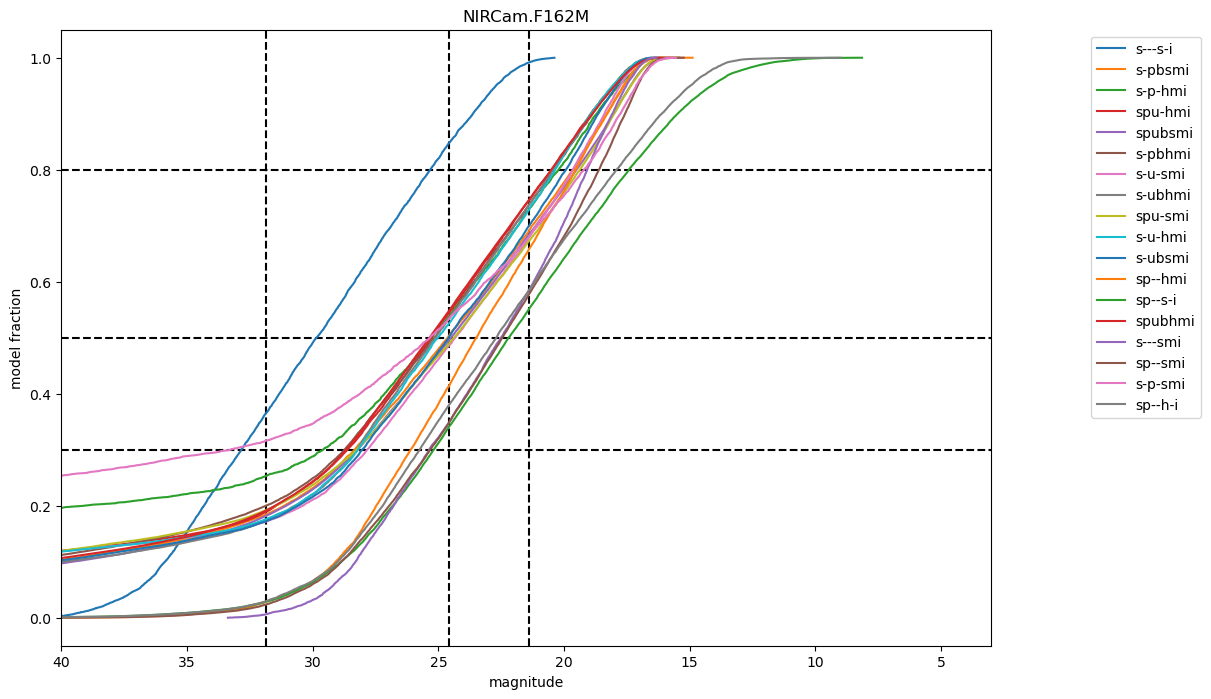

20.189004658330465 23.45916315697768 30.861117512215458


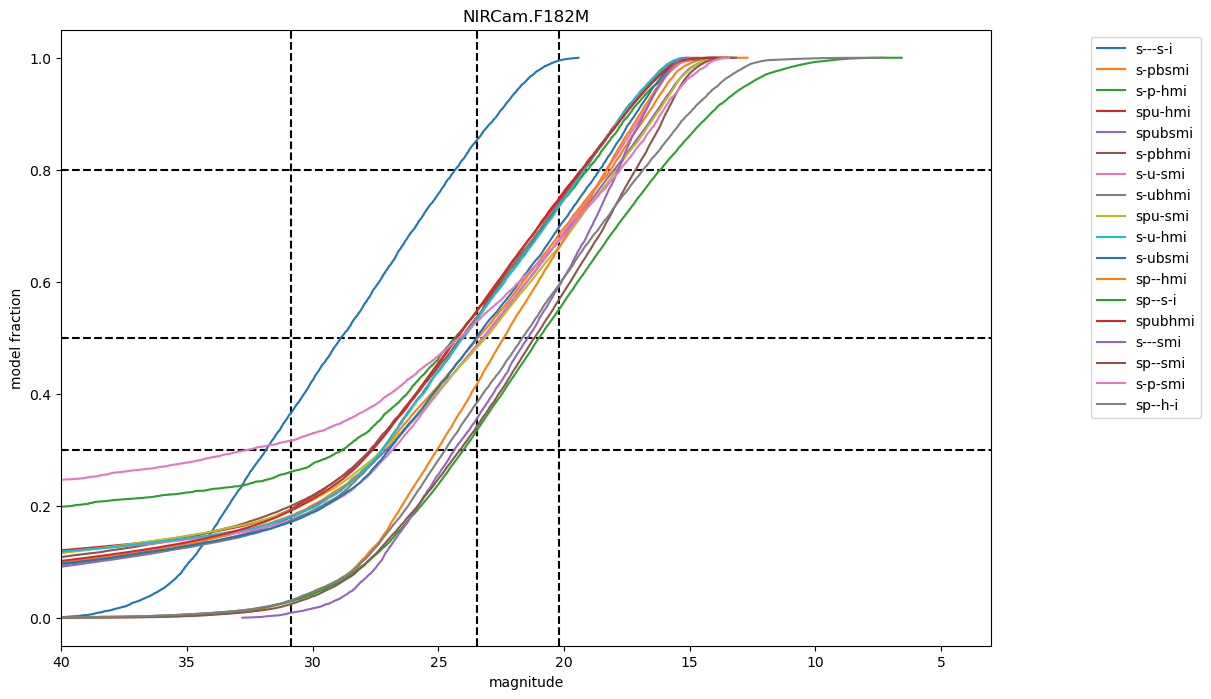

19.93247653261993 23.18870483346404 30.633396945024337


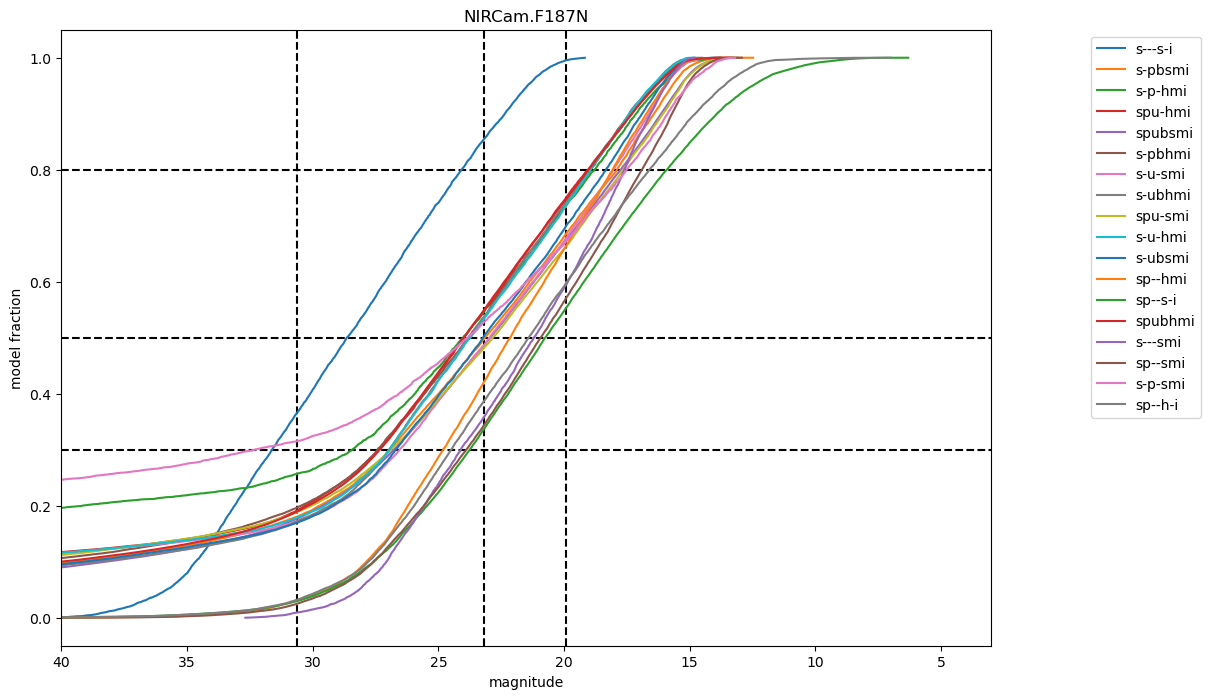

19.049923442307893 22.379551467296327 29.769245019381678


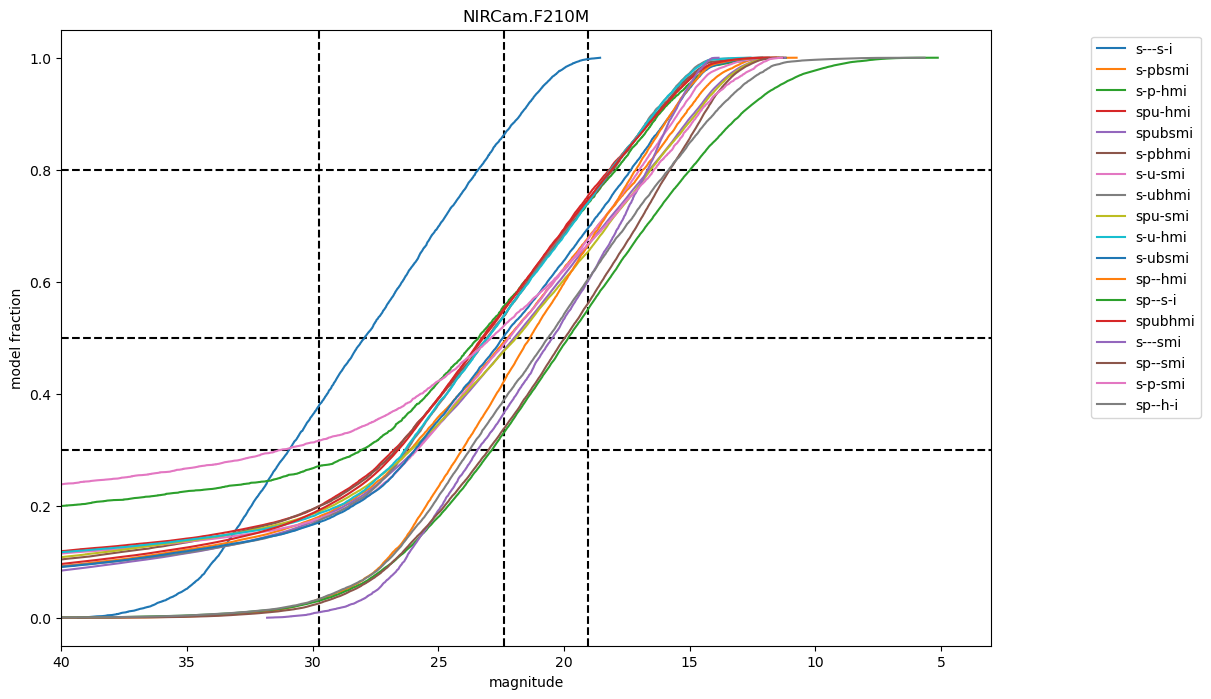

16.552361566736863 20.045459306632196 27.26370543470487


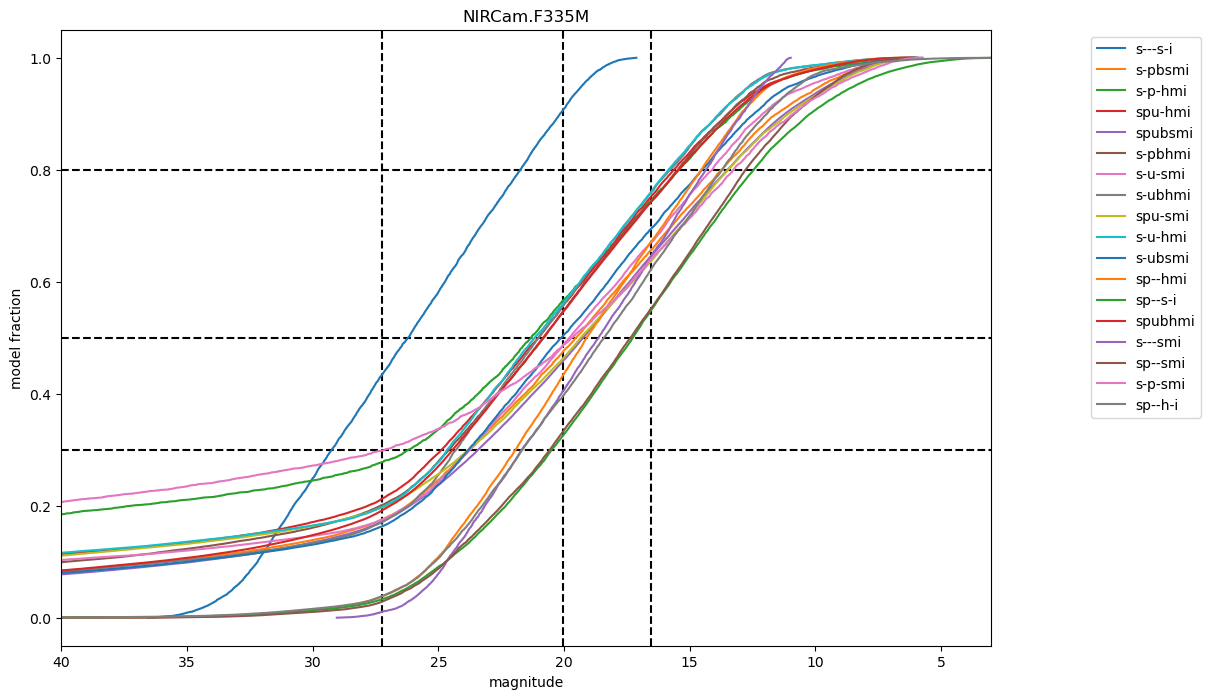

16.242891629150616 19.747975141903577 26.888645075923623


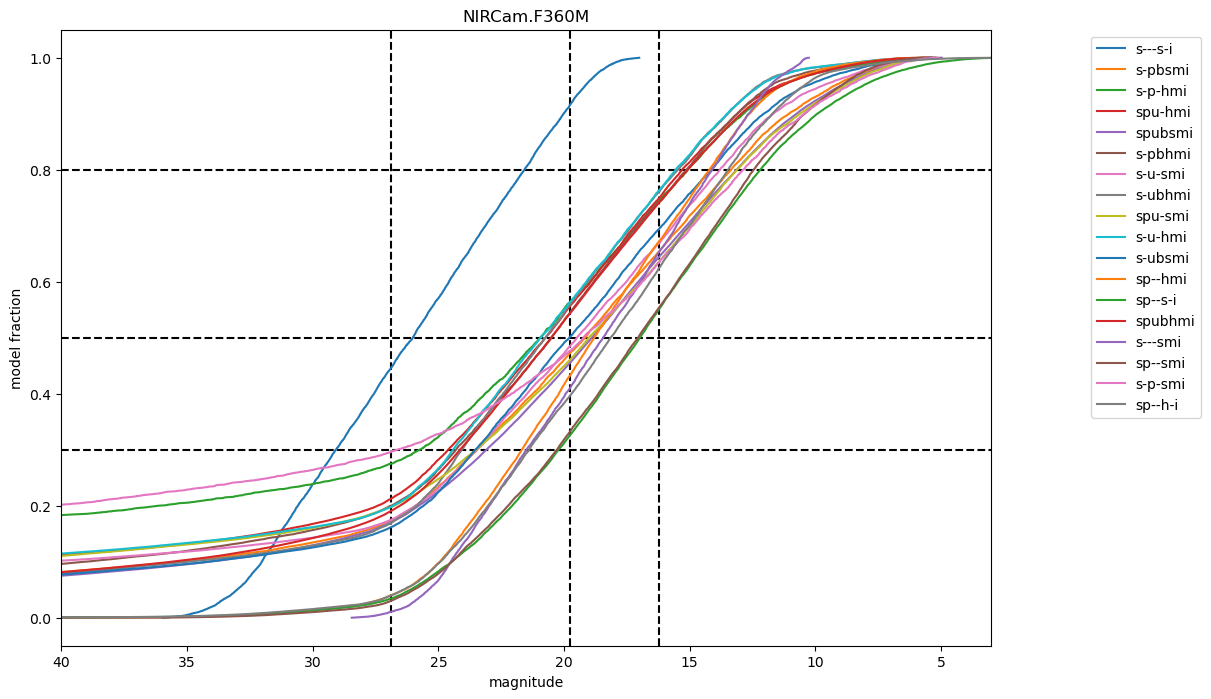

15.792217538138434 19.29491878073893 26.232243161617763


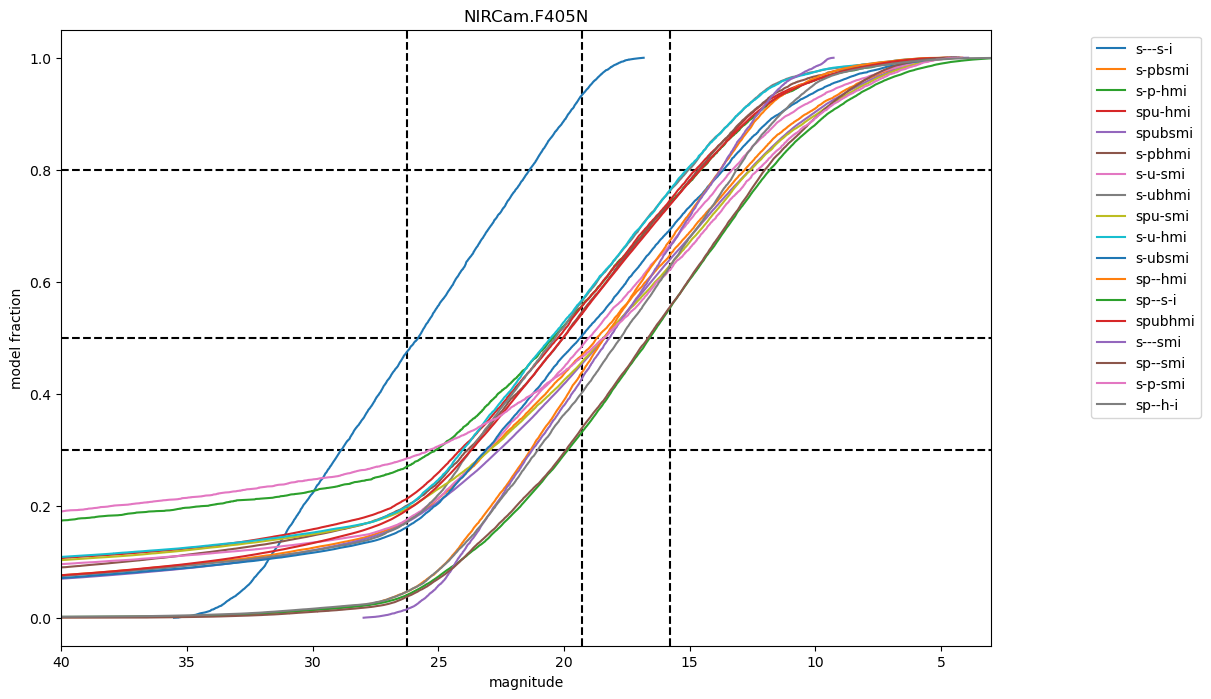

15.809287526084795 19.332618182636043 26.37317393204802


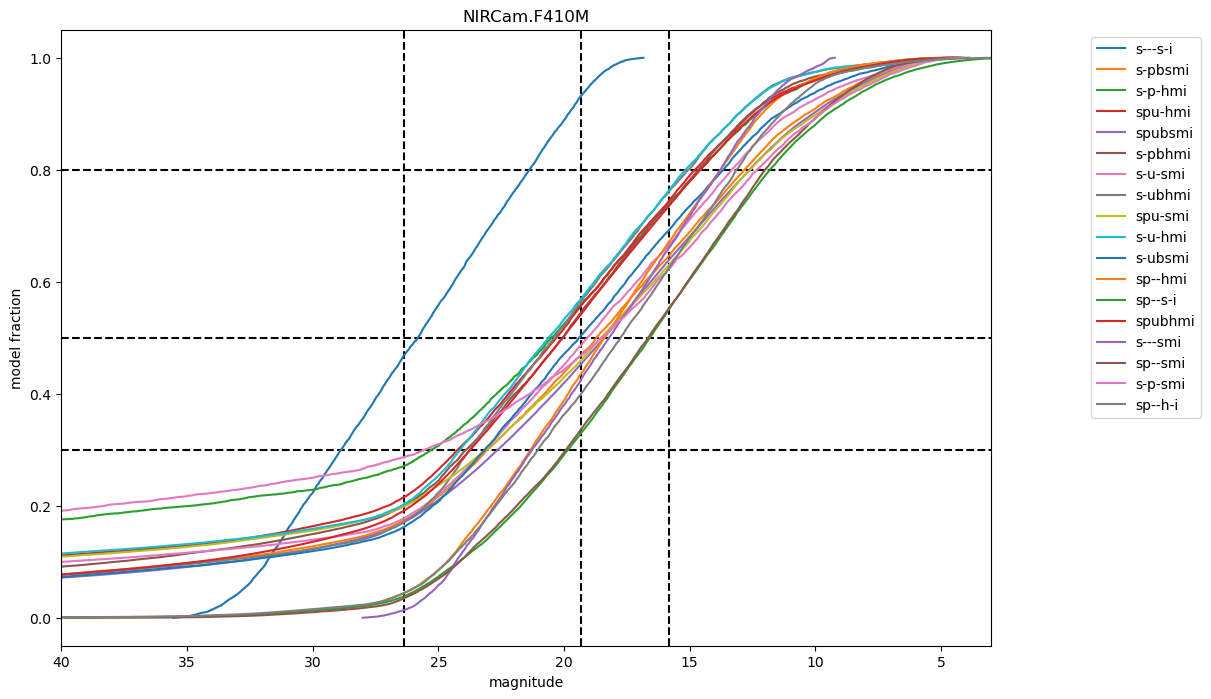

15.324920263199434 18.85016094371484 25.744515602692932


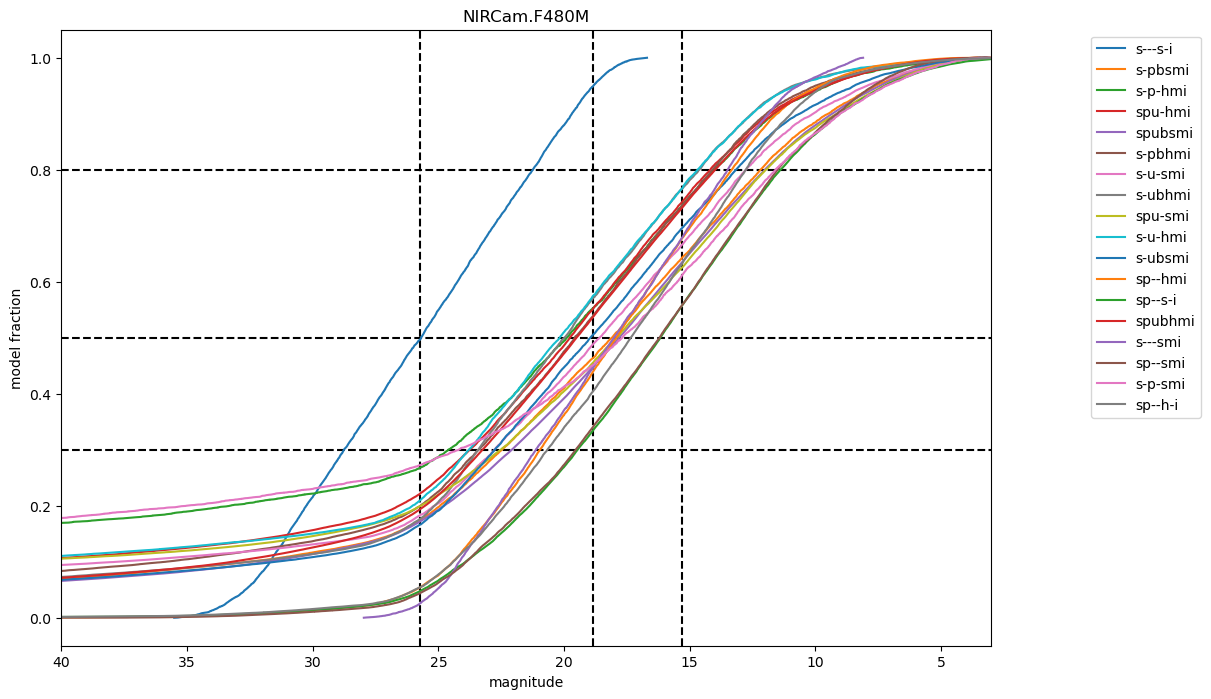

14.873585419552093 18.419390078581905 25.36011819175984


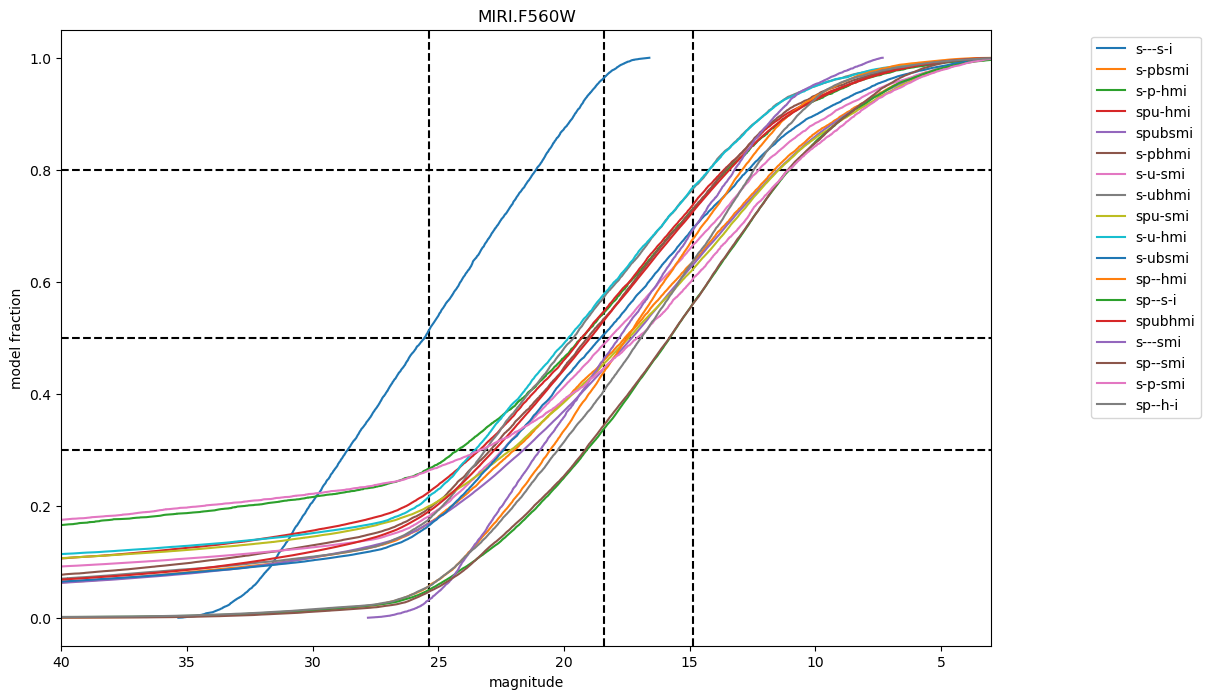

13.951286717933092 17.50335940487224 24.333333789610332


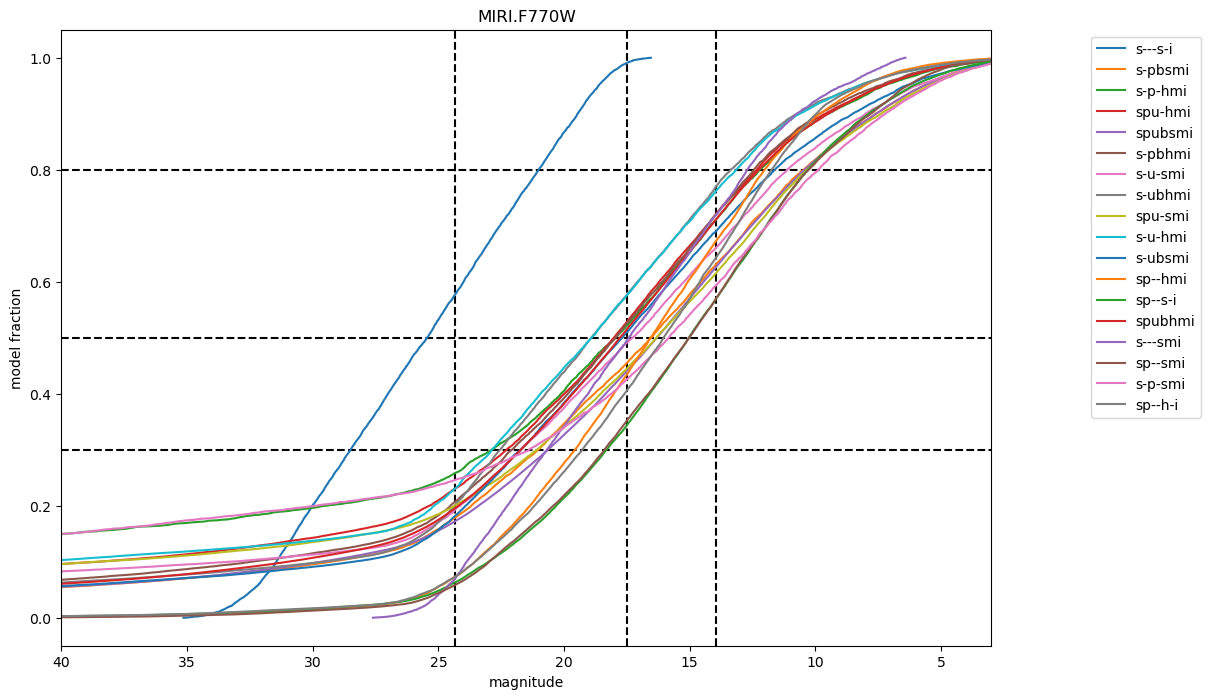

15.030254097227104 18.715157500958867 26.403764070862895


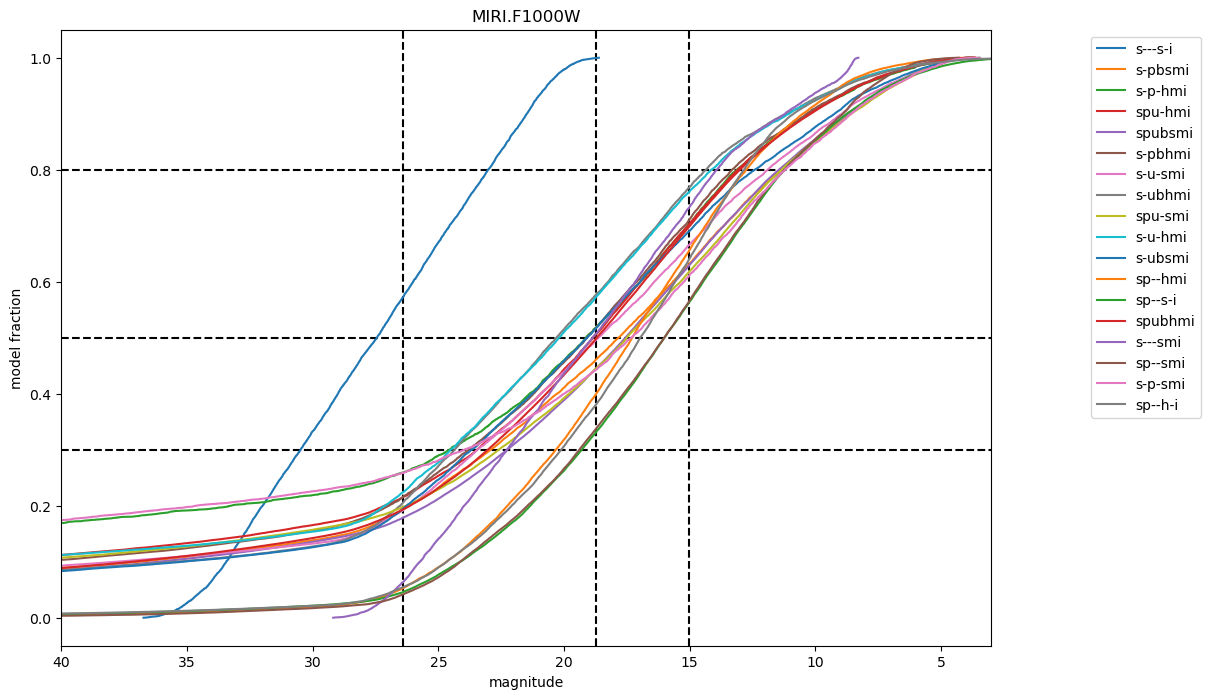

12.515906560382097 15.880656351995778 21.989551016587864


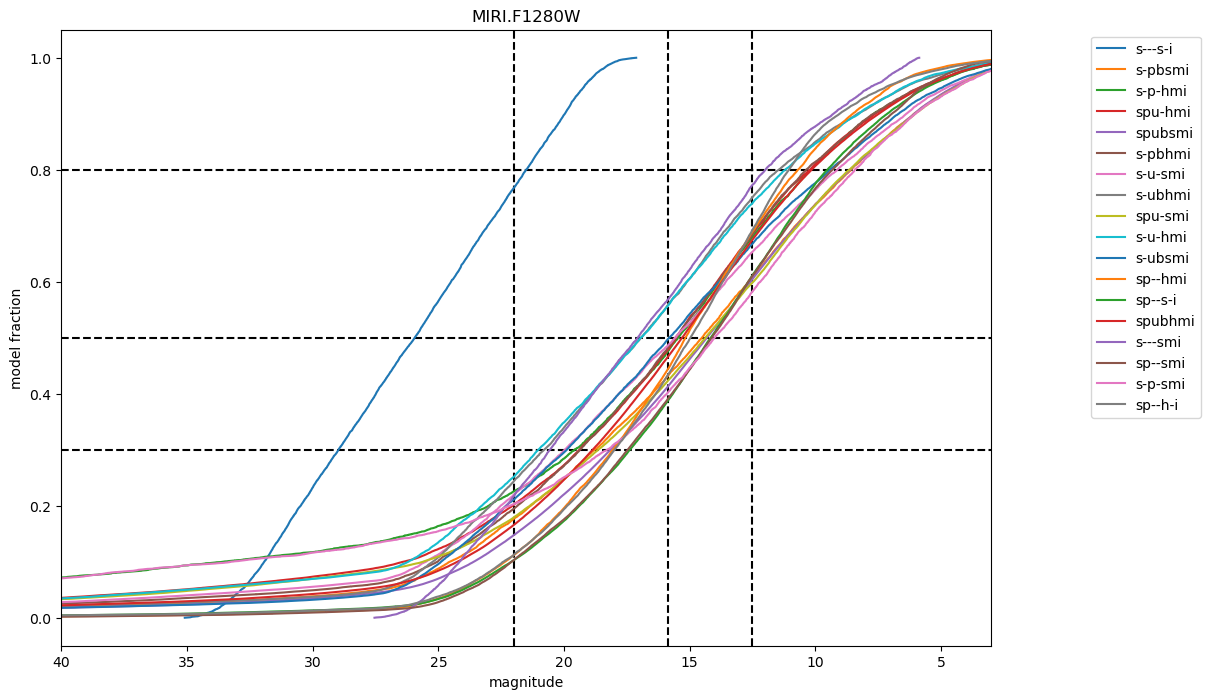

/scratch/local/13526413/ipykernel_3824669/1523028450.py:44: RuntimeWarning: invalid value encountered in log10
  mag = -2.5*np.log10(rslt / u.Quantity(jfilts.loc['JWST/'+band]['ZeroPoint'], u.Jy)) +  av * ext(wl_um) + distance_modulus


10.996699519652632 14.292872893715494 20.390152651171135


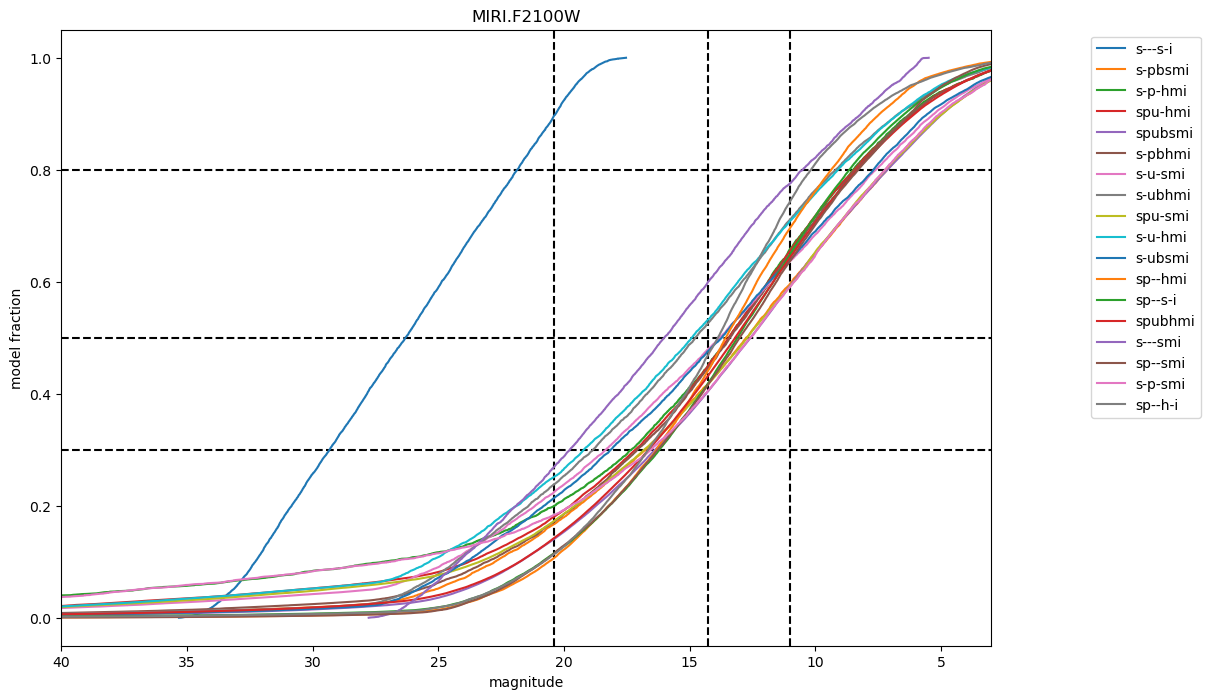

[21.387639394218823, 20.189004658330465, 19.93247653261993, 19.049923442307893, 16.552361566736863, 16.242891629150616, 15.792217538138434, 15.809287526084795, 15.324920263199434, 14.873585419552093, 13.951286717933092, 15.030254097227104, 12.515906560382097, 10.996699519652632] [24.569135396016904, 23.45916315697768, 23.18870483346404, 22.379551467296327, 20.045459306632196, 19.747975141903577, 19.29491878073893, 19.332618182636043, 18.85016094371484, 18.419390078581905, 17.50335940487224, 18.715157500958867, 15.880656351995778, 14.292872893715494] [31.8630267791112, 30.861117512215458, 30.633396945024337, 29.769245019381678, 27.26370543470487, 26.888645075923623, 26.232243161617763, 26.37317393204802, 25.744515602692932, 25.36011819175984, 24.333333789610332, 26.403764070862895, 21.989551016587864, 20.390152651171135] [1.62, 1.82, 1.87, 2.1, 3.35, 3.6, 4.05, 4.1, 4.8, 5.6, 7.7, 10.0, 12.8, 21.0]


In [24]:
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC, G21_MWAvg, D22_MWAvg,CT06_MWLoc
from dust_extinction.parameter_averages import CCM89
ext = CT06_MWLoc()

bandlist = ['NIRCam.F162M', 'NIRCam.F182M', 'NIRCam.F187N', 'NIRCam.F210M', 'NIRCam.F335M', 'NIRCam.F360M', 'NIRCam.F405N',
            'NIRCam.F410M', 'NIRCam.F480M', 'MIRI.F560W', 'MIRI.F770W', 'MIRI.F1000W', 'MIRI.F1280W', 'MIRI.F2100W']
av=30
distance_modulus = 5 * np.log10(540)
mags_30 = [] ; mags_50 = [] ; mags_80 = []
wls = []
geoms = [x.split("/")[-2] for x in glob.glob('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/*/')
         if x.split("/")[-2].startswith('s')]
for band in bandlist:            
    
        
        
    fig = pl.figure(figsize=(12,8))
    
    wl_um = int(band[-4:-1])*u.um/100
    if band == 'MIRI.F1000W' or band== 'MIRI.F1280W' or band=='MIRI.F2100W':
        wl_um = int(band[-5:-1])*u.um/100
    mag_30 = [] ; mag_50 = [] ; mag_80 = [] 
    for geom in geoms:

        geomtab = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/r+23_models-1.1/{geom}/convolved/JWST/{band}.fits')
         for geom in geoms}
        geomtab1 = geomtab[geom]
        
        pars = augpars_dict[geom]
        lum = pars['Model Luminosity']
        lumsel = lum>100

    
        pars = augpars_dict[geom]
        lum = pars['Model Luminosity']
        #lumsel = (lum > 0.05) & (lum < 0.5)
        #lumsel = lum>100
        if any(lumsel):
        #pl.hist(f470['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
            rslt = geomtab1['TOTAL_FLUX'][:, 5]
            rslt = rslt[np.isfinite(rslt)]
            rslt = np.sort(rslt)
            mag = -2.5*np.log10(rslt / u.Quantity(jfilts.loc['JWST/'+band]['ZeroPoint'], u.Jy)) +  av * ext(wl_um) + distance_modulus
            pl.plot(mag, np.arange(len(rslt)) / len(rslt), label=geom)
            mag_30.append(np.percentile(mag,30))
            mag_50.append(np.percentile(mag,50))
            mag_80.append(np.percentile(mag,80))
    mags_30.append(np.mean(mag_30))
    mags_50.append(np.mean(mag_50))
    mags_80.append(np.mean(mag_80))
    print(np.mean(mag_30), np.mean(mag_50), np.mean(mag_80))
    wls.append(wl_um.value)
    pl.legend(loc='upper left', bbox_to_anchor=(1.1,1))
    pl.axvline(np.mean(mag_30), linestyle='--', color='k', zorder=-50)
    pl.axhline(0.3, linestyle='--', color='k', zorder=-50)
    pl.axvline(np.mean(mag_50), linestyle='--', color='k', zorder=-50)
    pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
    pl.axvline(np.mean(mag_80), linestyle='--', color='k', zorder=-50)
    pl.axhline(0.8, linestyle='--', color='k', zorder=-50)
    pl.xlim(40, 3)
    pl.ylabel('model fraction')
    pl.xlabel('magnitude')
    pl.title(f'{band}')
    pl.show()
    pl.close()
print(mags_30,mags_50,mags_80,wls)

In [ ]:
import dust_extinction
from dust_extinction.averages import RRP89_MWGC, CT06_MWGC, F11_MWGC, G21_MWAvg, D22_MWAvg,CT06_MWLoc
from dust_extinction.parameter_averages import CCM89
ext = CT06_MWLoc()

bandlist = ['NIRCam.F162M', 'NIRCam.F182M', 'NIRCam.F187N', 'NIRCam.F210M', 'NIRCam.F335M', 'NIRCam.F360M', 'NIRCam.F405N',
            'NIRCam.F410M', 'NIRCam.F480M', 'MIRI.F560W', 'MIRI.F770W', 'MIRI.F1000W', 'MIRI.F1280W', 'MIRI.F2100W']
av=30
distance_modulus = 5 * np.log10(540)
mags_30 = [] ; mags_50 = [] ; mags_80 = []
wls = []
geoms = [x.split("/")[-2] for x in glob.glob('/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/*/')
         if x.split("/")[-2].startswith('s')]
for band in bandlist:            
    
        
        
    fig = pl.figure(figsize=(12,8))
    
    wl_um = int(band[-4:-1])*u.um/100
    if band == 'MIRI.F1000W' or band== 'MIRI.F1280W' or band=='MIRI.F2100W':
        wl_um = int(band[-5:-1])*u.um/100
    mag_30 = [] ; mag_50 = [] ; mag_80 = [] 
    for geom in geoms:

        geomtab = {geom: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/r+23_models-1.1/{geom}/convolved/JWST/{band}.fits')
         for geom in geoms}
        geomtab1 = geomtab[geom]
        
        pars = augpars_dict[geom]
        lum = pars['Model Luminosity']
        lumsel = lum>100

    
        pars = augpars_dict[geom]
        lum = pars['Model Luminosity']
        #lumsel = (lum > 0.05) & (lum < 0.5)
        #lumsel = lum>100
        if any(lumsel):
        #pl.hist(f470['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
            rslt = geomtab1['TOTAL_FLUX'][:, 5]
            rslt = rslt[np.isfinite(rslt)]
            rslt = np.sort(rslt)
            #mag = -2.5*np.log10(rslt / u.Quantity(jfilts.loc['JWST/'+band]['ZeroPoint'], u.Jy)) +  av * ext(wl_um) + distance_modulus
            mag = rslt
            pl.plot(mag, np.arange(len(rslt)) / len(rslt), label=geom)
            mag_30.append(np.percentile(mag,20))
            mag_50.append(np.percentile(mag,50))
            mag_80.append(np.percentile(mag,80))
    mags_30.append(np.mean(mag_30))
    mags_50.append(np.mean(mag_50))
    mags_80.append(np.mean(mag_80))
    print(np.mean(mag_30), np.mean(mag_50), np.mean(mag_80))
    wls.append(wl_um.value)
    pl.legend(loc='upper left', bbox_to_anchor=(1.1,1))
    pl.axvline(np.mean(mag_30), linestyle='--', color='k', zorder=-50)
    pl.axhline(0.2, linestyle='--', color='k', zorder=-50)
    pl.axvline(np.mean(mag_50), linestyle='--', color='k', zorder=-50)
    pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
    pl.axvline(np.mean(mag_80), linestyle='--', color='k', zorder=-50)
    pl.axhline(0.8, linestyle='--', color='k', zorder=-50)
    pl.xlim(1e-6, 1e7)
    pl.xscale('log')
    pl.ylabel('model fraction')
    pl.xlabel('flux')
    pl.title(f'{band}')
    
    pl.show()
    pl.close()
np.savetxt(
print(mags_30,mags_50,mags_80,wls)

In [ ]:
pl.figure(figsize=(8,6), dpi=150)
data = []
for lumlo, lumhi in ([(0.005, 0.05), (0.05, 0.5), (0.5, 5), (5, 50), (50, 500)]):
    for geom in geoms:
        pars = augpars_dict[geom]
        f480 = f480s[geom]
        lum = pars['Model Luminosity']
        lumsel = (lum > lumlo) & (lum <= lumhi)
        if any(lumsel):
            #pl.hist(f480['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
            rslt = f480['TOTAL_FLUX'][lumsel, 5]
            rslt = rslt[np.isfinite(rslt)]
            rslt = np.sort(rslt)
            data = np.hstack([data, rslt])
            #pl.plot(rslt / (8.5**2), np.arange(len(rslt)) / len(rslt), label=geom)
    data = np.sort(data)
    magdata = -2.5*np.log10((u.Quantity(data, u.mJy).to(u.Jy) / (8.5**2)) / u.Quantity(jfilts.loc['JWST/NIRCam.F480M']['ZeroPoint'], u.Jy))
    L, = pl.plot(magdata.value, np.arange(len(data)) / len(data))
    #print(np.median(magdata))
    medmag = np.median(magdata).value
    #print(medmag)
    pl.axvline(medmag, linestyle=':', zorder=-100, color=L.get_color(), label=f'{lumlo:0.1g} < L < {lumhi:0.1g}: $M_{{med}}={medmag:0.1f}$')
    #pl.axvline(22.5, linestyle='--', color='k', zorder=-50)
pl.legend(loc='best')# bbox_to_anchor=(1.1,1))
pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
pl.xlabel("[F480M] mag")
pl.ylabel("Fraction of Sources")
pl.xlim(25, 9);

In [ ]:
pl.figure(figsize=(8,6), dpi=150)
data = []
for lumlo, lumhi in ([(0.005, 0.05), (0.05, 0.5), (0.5, 5), (5, 50), (50, 500)]):
    for geom in geoms:
        pars = augpars_dict[geom]
        f212 = f212s[geom]
        lum = pars['Model Luminosity']
        lumsel = (lum > lumlo) & (lum <= lumhi)
        if any(lumsel):
            #pl.hist(f212['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
            rslt = f212['TOTAL_FLUX'][lumsel, 5]
            rslt = rslt[np.isfinite(rslt)]
            rslt = np.sort(rslt)
            data = np.hstack([data, rslt])
            #pl.plot(rslt / (8.5**2), np.arange(len(rslt)) / len(rslt), label=geom)
    data = np.sort(data)
    magdata = -2.5*np.log10((u.Quantity(data, u.mJy).to(u.Jy) / (8.5**2)) / u.Quantity(jfilts.loc['JWST/NIRCam.F212N']['ZeroPoint'], u.Jy))
    L, = pl.plot(magdata.value, np.arange(len(data)) / len(data))
    #print(np.median(magdata))
    medmag = np.median(magdata).value
    #print(medmag)
    pl.axvline(medmag, linestyle=':', zorder=-100, color=L.get_color(), label=f'{lumlo:0.1g} < L < {lumhi:0.1g}: $M_{{med}}={medmag:0.1f}$')
    #pl.axvline(22.5, linestyle='--', color='k', zorder=-50)
pl.legend(loc='best')# bbox_to_anchor=(1.1,1))
pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
pl.xlabel("[F212N] mag")
pl.ylabel("Fraction of Sources")
pl.xlim(25, 9);

In [ ]:
v1[:5]

In [ ]:
v2[:5]

In [ ]:
pl.scatter(v1['TOTAL_FLUX'][:,5], v2['TOTAL_FLUX'][:,5])

In [ ]:
pl.hist(-2.5*np.log10(v2['TOTAL_FLUX'][:,5]/666000))

In [ ]:
%matplotlib inline
import pylab as pl

In [ ]:
from astropy.table import Table
from astropy.visualization import simple_norm

In [ ]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [ ]:
mist = Table.read(f'{basepath}/isochrones/MIST_iso_633a08f2d8bb1.iso.cmd',
                  header_start=12, data_start=13, format='ascii', delimiter=' ', comment='#')
mist['410M405'] = mist['F410M']
mist['405M410'] = mist['F405N']

In [ ]:
distance_modulus = 5*np.log10(8500)-5
distance_modulus

In [ ]:
from astropy.visualization import simple_norm

In [ ]:
f212s['s---s-i'][:5]

In [ ]:
pl.figure(dpi=150)

norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(mist['F210M'][agesel] - mist['F480M'][agesel],
                   (mist['F210M'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )

        
cb = pl.colorbar()
cb.set_ticks([0.5,1,5,10,50,250])
cb.set_label("Mass")

mag212 = (u.Quantity(f212s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
mag480 = (u.Quantity(f480s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
#pl.scatter(mag212-mag480, mag212, s=1, zorder=-10)

#pl.axhline(0, linestyle='--', color='k')
#pl.axvline(0, linestyle='--', color='k')
pl.xlabel("[F210M]-[F480M]")
pl.ylabel("[F210M]")
#pl.axis([-0.2,0.1,-0.1,0.3])
pl.ylim(25,3)
pl.xlim([-0.25, 0.5]);
#agesel.sum()

In [ ]:
distance_modulus

In [ ]:
#mag212b = -2.5*np.log10(tables[2.12*u.um]['TOTAL_FLUX'][sel, 0] / jfilts.loc['JWST/NIRCam.F212N']['ZeroPoint'])
#mag480b = -2.5*np.log10(tables[4.80*u.um]['TOTAL_FLUX'][sel, 0] / jfilts.loc['JWST/NIRCam.F480M']['ZeroPoint'])
mag212 = -2.5*np.log10((u.Quantity(f212s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F212N']['ZeroPoint'], u.Jy))
mag480 = -2.5*np.log10((u.Quantity(f480s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F480M']['ZeroPoint'], u.Jy))

In [ ]:
pl.figure(dpi=150)

norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(mist['F212N'][agesel] - mist['F480M'][agesel],
                   (mist['F212N'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )

        
cb = pl.colorbar()
cb.set_ticks([0.5,1,5,10,50,250])
cb.set_label("Mass")

#mag212 = (u.Quantity(f212s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
#mag480 = (u.Quantity(f480s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
geom = 's---s-i'
mag212 = -2.5*np.log10((u.Quantity(f212s[geom]['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F212N']['ZeroPoint'], u.Jy))
mag480 = -2.5*np.log10((u.Quantity(f480s[geom]['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F480M']['ZeroPoint'], u.Jy))
pl.scatter(mag212-mag480, mag212, s=1, c=augpars_dict[geom]['star.temperature'], zorder=-10)

#pl.axhline(0, linestyle='--', color='k')
#pl.axvline(0, linestyle='--', color='k')
pl.xlabel("[F212N]-[F480M]")
pl.ylabel("[F212N]")
#pl.axis([-0.2,0.1,-0.1,0.3])
pl.ylim(25,3)
pl.xlim([-0.5, 1.5]);
#agesel.sum()

In [ ]:
pl.figure(dpi=150)

norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
for age in np.unique(mist['log10_isochrone_age_yr']):
    if age in (5,6,7,8):
    
        agesel = mist['log10_isochrone_age_yr'] == age
        pl.scatter(mist['F212N'][agesel] - mist['F480M'][agesel],
                   (mist['F212N'])[agesel]+distance_modulus,
                   c=mist['initial_mass'][agesel],
                   norm=norm,
                   cmap='inferno',
                   alpha=0.5,
                   s=1,
                  )

        
cb = pl.colorbar()
cb.set_ticks([0.5,1,5,10,50,250])
cb.set_label("Mass")

#mag212 = (u.Quantity(f212s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
#mag480 = (u.Quantity(f480s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
geom = 'spubhmi'
mag212 = -2.5*np.log10((u.Quantity(f212s[geom]['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F212N']['ZeroPoint'], u.Jy))
mag480 = -2.5*np.log10((u.Quantity(f480s[geom]['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F480M']['ZeroPoint'], u.Jy))
pl.scatter(mag212-mag480, mag212, s=1,
           c=np.log10(augpars_dict[geom]['Model Luminosity']),
           alpha=0.01, zorder=-10)
pl.title(geom)
cb2 = pl.colorbar()
cb2.set_label("log YSO Luminosity")
cb2.set_alpha(1)
cb2.draw_all()

#pl.axhline(0, linestyle='--', color='k')
#pl.axvline(0, linestyle='--', color='k')
pl.xlabel("[F212N]-[F480M]")
pl.ylabel("[F212N]")
#pl.axis([-0.2,0.1,-0.1,0.3])
pl.ylim(26,3)
pl.xlim([-0.75, 3.5]);
#agesel.sum()

In [ ]:
for geom in augpars_dict:
    pl.figure(dpi=150)

    norm = simple_norm(mist['initial_mass'][mist['log10_isochrone_age_yr'] < 7], stretch='log')
    for age in np.unique(mist['log10_isochrone_age_yr']):
        if age in (5,6,7,8):

            agesel = mist['log10_isochrone_age_yr'] == age
            pl.scatter(mist['F212N'][agesel] - mist['F480M'][agesel],
                       (mist['F212N'])[agesel]+distance_modulus,
                       c=mist['initial_mass'][agesel],
                       norm=norm,
                       cmap='inferno',
                       alpha=0.5,
                       s=1,
                      )


    cb = pl.colorbar()
    cb.set_ticks([0.5,1,5,10,50,250])
    cb.set_label("Mass")

    #mag212 = (u.Quantity(f212s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
    #mag480 = (u.Quantity(f480s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
    mag212 = -2.5*np.log10((u.Quantity(f212s[geom]['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F212N']['ZeroPoint'], u.Jy))
    mag480 = -2.5*np.log10((u.Quantity(f480s[geom]['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2) / u.Quantity(jfilts.loc['JWST/NIRCam.F480M']['ZeroPoint'], u.Jy))
    pl.scatter(mag212-mag480, mag212, s=1,
               c=np.log10(augpars_dict[geom]['Model Luminosity']),
               alpha=0.01, zorder=-10)
    #pl.title(geom)
    cb2 = pl.colorbar()
    cb2.set_label("log YSO Luminosity")
    cb2.set_alpha(1)
    cb2.draw_all()

    #pl.axhline(0, linestyle='--', color='k')
    #pl.axvline(0, linestyle='--', color='k')
    pl.xlabel("[F212N]-[F480M]")
    pl.ylabel("[F212N]")
    #pl.axis([-0.2,0.1,-0.1,0.3])
    pl.ylim(26,3)
    pl.xlim([-0.75, 3.5]);
    #agesel.sum()
    pl.savefig(f"JWST_F212NF480M_CMD_{geom}.png", bbox_inches='tight')

In [ ]:
mist['log_L'].max()

In [ ]:
mag212 = (u.Quantity(f212s['spubsmi']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
mag480 = (u.Quantity(f480s['spubsmi']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
pl.scatter(mag212-mag480, mag212, s=1, alpha=0.1)
pl.axis([-5,5,20,0])

In [ ]:
mag212 = (u.Quantity(f212s['spubhmi']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
mag480 = (u.Quantity(f480s['spubhmi']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
pl.scatter(mag212-mag480, mag212, s=1, alpha=0.1)
pl.axis([-5,5,20,0])

In [ ]:
5 * np.log10(8.5)

In [ ]:
(f212s['s---s-i']['TOTAL_FLUX'].quantity).to(u.ABmag)[:,5].min().value + 5 * np.log10(8.5)

In [ ]:
(f212s['s---s-i']['TOTAL_FLUX'].quantity).to(u.ABmag)[:,5].min().value - 5

In [ ]:
(-2.5*np.log10(f212s['s---s-i']['TOTAL_FLUX'].quantity/(666*u.Jy))).min() - 5

In [ ]:
augpars_dict['s---s-i']

In [ ]:
augpars_dict['s---s-i']['star.temperature']

In [ ]:
pl.semilogx(augpars_dict['s---s-i']['Model Luminosity'], (-2.5*np.log10(f212s['s---s-i']['TOTAL_FLUX'][:,5].quantity/(666*u.Jy))),
           )
           #c=np.array(augpars_dict['s---s-i']['star.temperature'], dtype='float'))


In [ ]:
mag212 = (u.Quantity(f212s['spubhmi']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
mag480 = (u.Quantity(f480s['spubhmi']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
pl.scatter(mag212-mag480, mag212, s=1, alpha=0.1)
pl.axis([-5,5,20,0])

In [ ]:
mag212 = (u.Quantity(f212s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
mag480 = (u.Quantity(f480s['s---s-i']['TOTAL_FLUX'][:,5], u.mJy) / 8.5**2).to(u.ABmag)
pl.scatter(mag212-mag480, mag212, s=1, alpha=0.1)
pl.axis([-5,5,20,0])

In [ ]:
augpars_dict['spubsmi']

In [ ]:
pl.figure(figsize=(8,6), dpi=150)
data = []
for lumlo, lumhi in ([(0.05, 0.5), (0.5, 5), (5, 50), (50, 500), (500, 5000), (5e3, 5e4), (5e4, 5e5), (5e5, 5e6), (5e6, 5e7)]):
    for geom in geoms:
        pars = augpars_dict[geom]
        f212 = f212s[geom]
        lum = pars['Model Luminosity']
        lumsel = (lum > lumlo) & (lum <= lumhi)
        if any(lumsel):
            #pl.hist(f212['TOTAL_FLUX'][lumsel, 5], bins=np.geomspace(0.01, 10), label=geom)
            rslt = f212['TOTAL_FLUX'][lumsel, 5]
            rslt = rslt[np.isfinite(rslt)]
            rslt = np.sort(rslt)
            data = np.hstack([data, rslt])
            #pl.plot(rslt / (8.5**2), np.arange(len(rslt)) / len(rslt), label=geom)
    data = np.sort(data)
    magdata = (u.Quantity(data, u.mJy) / (8.5**2)).to(u.ABmag)
    L, = pl.plot(magdata.value, np.arange(len(data)) / len(data))
    #print(np.median(magdata))
    medmag = np.median(magdata).value
    #print(medmag)
    pl.axvline(medmag, linestyle=':', zorder=-100, color=L.get_color(), label=f'{lumlo:0.1g} < L < {lumhi:0.1g}: $M_{{med}}={medmag:0.1f}$')
    #pl.axvline(22.5, linestyle='--', color='k', zorder=-50)
pl.legend(loc='best')# bbox_to_anchor=(1.1,1))
pl.axhline(0.5, linestyle='--', color='k', zorder=-50)
pl.xlabel("[F212N] mag")
pl.ylabel("Fraction of Sources")
pl.xlim(26, 4);

In [ ]:

fig = pl.figure(figsize=(10, 10), dpi=150)

combos = [(colors_N[ii-1], colors_N[jj-1]) for ii,jj in ((2,3), (2,4), (1,5), (2,3),) ]
gridspec = sqgrid.get_grid(len(combos));

xarr = np.linspace(1, 5, 10000)*u.um
rawspec = np.ones(xarr.size, dtype=float)*u.Jy
av = 30


for ii, (color1, color2) in enumerate(combos):
    ax = fig.add_subplot(gridspec[ii])
    for geom, cmap in zip(('spubsmi', 'sp--smi',), ('viridis', 'inferno')):
        Lgt1 = augpars_dict[geom]['Model Luminosity'] > 1
        tbs = {cname: Table.read(f'/blue/adamginsburg/richardson.t/research/flux/robitaille_models-1.2/{geom}/convolved/JWST/{cname}.fits')
               for cname in color1 + color2}
        keys1 = [col for col in color1]
        keys2 = [col for col in color2]
        colorp1 = -2.5*np.log10(tbs[keys1[0]]['TOTAL_FLUX'][:, 5]) + 2.5*np.log10(tbs[keys1[1]]['TOTAL_FLUX'][:, 5])
        colorp2 = -2.5*np.log10(tbs[keys2[0]]['TOTAL_FLUX'][:, 5]) + 2.5*np.log10(tbs[keys2[1]]['TOTAL_FLUX'][:, 5])
        sc = ax.scatter(colorp1[Lgt1], colorp2[Lgt1], s=2, alpha=0.1,
                        c=np.log10(augpars_dict[geom]['Model Luminosity'])[Lgt1],
                        norm=simple_norm(np.log10(augpars_dict[geom]['Model Luminosity'])[Lgt1], stretch='linear',
                                      min_cut=0, max_cut=5),
                        cmap=cmap
                       )#(np.log10(augpars['Model Luminosity'])))
    #ax.scatter(colorp1[sel], colorp2[sel], s=5, alpha=0.5, c='r')
    ax.set_xlabel(f"{color1[0]} - {color1[1]}")
    ax.set_ylabel(f"{color2[0]} - {color2[1]}")
    ax.axis((-2,5,-2,5))
    cb = pl.colorbar(mappable=sc, ax=ax)
    cb.set_label('log Luminosity')
    wl1_um = int(color1[0][-4:-1])*u.um/100
    wl2_um = int(color1[1][-4:-1])*u.um/100
    wl3_um = int(color2[0][-4:-1])*u.um/100
    wl4_um = int(color2[1][-4:-1])*u.um/100
    extcol1 = av * (ext(wl1_um) - ext(wl2_um))
    extcol2 = av * (ext(wl3_um) - ext(wl4_um))

    for molecule, column, ccc in zip(('co', 'h2o', 'co2'),
                                      # normalized to a_v=30 in fig7 of boogert / Tb 2 of boogert
                             (1e-5 * av * 1e21, 4e-5 * av * 1e21, 1.3e-5*av*1e21),
                             ('orange', 'purple', 'red')):
        moldata = molecule_data[molecule]
        consts = load_molecule(molecule)
        spec = absorbed_spectrum(column*u.cm**-2, consts,
                                 molecular_weight=moldata['molwt'],
                                 spectrum=rawspec,
                                 xarr=xarr,
                                )
        flxd = fluxes_in_filters(xarr, spec)
        flxd_raw = fluxes_in_filters(xarr, rawspec)
        icecolor1 = flxd['JWST/'+color1[0]].to(u.ABmag).value - flxd['JWST/'+color1[1]].to(u.ABmag).value
        icecolor2 = flxd['JWST/'+color2[0]].to(u.ABmag).value - flxd['JWST/'+color2[1]].to(u.ABmag).value

        arrow_start = (0, 0)
        arrow_end = (0 + icecolor1, 0 + icecolor2)
        print(arrow_start, arrow_end)
        ax.annotate('', arrow_end, arrow_start,
            arrowprops=dict(width=1, headwidth=5, headlength=5,
            edgecolor=ccc,
            facecolor=ccc, ),
            color=ccc,
           )

    arrow_start = (0, 0)
    arrow_end = (0 + extcol1, 0 + extcol2)
    print(arrow_start, arrow_end)
    ax.annotate('', arrow_end, arrow_start,
        arrowprops=dict(width=1, headwidth=5, headlength=5,
        edgecolor='k',
        facecolor='k', ),
        color='k',
       )    
    
fig.suptitle('spubsmi for L$>1$ L$_\\odot$');